# I. Quantum Simulation of the XXX Heisenberg Spin Model with IBMQ Jakarta

__IBM Quantum - The Open Science Prize 2021__


Urbano L França

__Contents__

I. [Quantum Simulation of the XXX Heisenberg Spin Model with Jakarta](#Quantum-Simulation-of-the-XXX-Heisenberg-Spin-Model-with-IBMQ-Jakarta)

II. [The XXX Heisenberg Spin Model](II.-The-XXX-Heisenberg-Spin-Model)

III. [Qiskit](#III.-Qiskit)

IV. [Qiskit Native Gates](#IV.-Qiskit-Native-Gates)

V. [Pulse Efficient Gates with Template Optimization](#V.-Pulse-Efficient-Gates-with-Template-Optimization)

VI. [Jakarta Experiments](#VI.-Jakarta-Experiments)

VII. [Future Directions](#VII.-Futire-Directions)

VIII. [References](#VIII.-References)

## I.1 Introduction





## I.2 Objective of The Open Science Prize

From [The Open Science 2021 description](https://github.com/qiskit-community/open-science-prize-2021):


> One of the leading uses for quantum computers will be to simulate quantum systems such as molecules or engineered materials. Actually executing a quantum simulation on a current quantum computer, however, can be difficult and error prone. Your objective for this Open Science Prize is to significantly improve the state-of-the-art for quantum simulation.
>
> The quantum system you will simulate is a quantum spin-1/2 model, where each qubit represents a quantum [spin-1/2](https://en.wikipedia.org/wiki/Spin-1/2) particle in a 1D chain. Quantum spin models have some amazing properties and uses. Computationally speaking, [certain optimization problems can be mapped](https://arxiv.org/pdf/1712.05771.pdf) to spin models and hence minimized on a quantum computer. Physically speaking, spin models show a variety of quantum behavior such as large entangled states, quantum phases of matter, quantum many-body affects, and many other open questions in physics research.
>
> There are many different spin models, but we will focus on the [$XXX$ Heisenberg spin model](https://en.wikipedia.org/wiki/Quantum_Heisenberg_model#XXX_model). Though it is not as well known as the [transverse-field Ising model](https://en.wikipedia.org/wiki/Transverse-field_Ising_model), the $XXX$ Heisenberg model is of practical and theoretical interest. It can also be difficult to simulate, which is where you come in.
>
>[...]
>
>You are to time evolve the state $|110\rangle$ to time $t=\pi$ under the $XXX$ Heisenberg model Hamiltonian $H_{\text{heis3}}$ as defined in Section 1. This will be done on the ibmq_jakarta quantum computer. From left to right, the qubits in $|110\rangle$ correspond to ibmq_jakarta's qubits 5, 3, and 1. The evolution must be done using Trotterization with at least 4 steps ($n\geq4$). You will be judged on the clarity, originiality, and creativity of your solution, as well as the fidelity of the evolved state at time $t=\pi$ using [state tomography](https://qiskit.org/documentation/tutorials/noise/8_tomography.html). State tomography is a way of determining the exact quantum state--even phase information--at the end of a quantum circuit by running the circuit multiple times and measuring in different bases. The closer your final quantum state to the expected state, the higher the fidelity. Ibmq_jakarta's qubits 0, 2, 4, and 6 will not be evaluated by the state tomography calculation, so you may use them as you wish. You do not need to follow the same decomposition given in the example above, but your solution must be a Trotterization of $U_{\text{heis3}}(t)$ with at least 4 steps ($n\geq4$). You may find it useful to implement techniques that reduce errors and improve qubit coherence.


## I.3 Approach


* Describe here, including refs to Stenger+, Earnest +, etc

* why $R_{ZX}$ gates -> CNOT already using this calibration

* comment on balance of number of Trotter steps approx and the errors of each gate

* CR pulses

======

We will use pulse efficient implementation of gates with measurement error mitigation...

and the best results of each simulation are executed in the actual Jakarta device

incrementally implement tools to improve the results of the simulation to attempt to achieve  
Our final  apply the methodology of Earnest et al. [[Earnest et al. 2021]](https://arxiv.org/abs/2105.01063) to implement This notebook is organized as follows:

===========

This notebook is organized as follows: in Section [II](II.-The-XXX-Heisenberg-Spin-Model) we describe the XXX Heisenberg spin model, the decomposition of the Hamiltonian operator into quantum gates using the Suzuki-Trotterization decomposition. This discussion follows closely the [original notebooks](https://github.com/qiskit-community/open-science-prize-2021) provided by the organizers of the Open Science Prize 2021. Sec. [III](#III.-Qiskit) imports the packages and backends which will be used in the notebook and contains some functions that will be used in the simulations and device executions. 

In the subsequent two sections, we use several approaches to simulate the Heisenberg model and compare their results. These tests are run on a Jakarta simulator, `FakeJakarta` and are executed using between 4 and 13 Trotter steps to evaluate their performance with increasing Trotterization. In Sec. [IV](#IV.-Standard-Gates) we use the standard implementation of gates in Qiskit to run 4 different sets of experiments that will provide the baseline to compare the pulse efficient solutions. We perform a noiseless test, a non-optimized quantum circuit execution, an optimized quantum circuit execution, and an optimized quantum circuit execution followed by measurement error mitigation using the Qiskit implementation of measurement calibration. In Sec. [V](#V.-Pulse-Efficient-Gates-with-Template-Optimization) we discuss pulse efficient template optimization and implement this approach to generate pulse efficient versions of the $XX(\theta)$, $YY(\theta)$, and $ZZ(\theta)$ gates. After comparing these gates with their standard, CNOT-implemented counterparts, we demonstrate their performance with and without post-processing of the results by applying measurement error mitigation. Finally, with the result of these experiments, in Sec. [VI](#VI.-Jakarta-Experiments) we execute the circuits with higher performance on `ibmq_jakarta` and report their final results on the actual device. 

# II. The XXX Heisenberg Spin Model

In this section we brief summarize the description of the XXX Heisenberg spin model deliineated in the [original notebooks](https://github.com/qiskit-community/open-science-prize-2021) for the Open Science Prize 2021.

The Heisenberg model is described by the Hamiltonian operator,

$$
H_{\text{Heis}} = \sum_{\langle ij \rangle}^{N} J \left(\sigma_x^{(i)}\sigma_x^{(j)} + \sigma_y^{(i)}\sigma_y^{(j)} + \sigma_z^{(i)}\sigma_z^{(j)}\right).
$$

where $N$ is the total number of spin 1/2 particles in the model, $J$ is the interaction strength, $\langle ij \rangle$ denotes a sum running over the nearest neighbors, and $\sigma_x$, $\sigma_y$, and $\sigma_z$ are [Pauli operators](https://en.wikipedia.org/wiki/Pauli_matrices). In the particular case of this challenge, we will work with $N=3$ and  $J=1$, corresponding to the Hamiltonian,

$$
H_{\text{Heis3}} = 
\sum_{\langle ij \rangle}^{3} \left(\sigma_x^{(i)}\sigma_x^{(j)} + \sigma_y^{(i)}\sigma_y^{(j)} + \sigma_z^{(i)}\sigma_z^{(j)}\right) .
$$

Since this Hamiltonian is time independent, we can write the solution to the [Schrödinger equation](https://en.wikipedia.org/wiki/Schrödinger_equation) as 

$$
|\psi(t)\rangle = e^{-it H_\text{Heis3}}|\psi(t=0)\rangle  = U_{\text{Heis3}}(t)|\psi(t=0)\rangle , 
$$

where we use natural units ($\hbar = 1$) and the unitary operator is given by

$$
U_{\text{Heis3}}(t) 
= \exp\left[-it \sum_{\langle ij \rangle}^{3} \left(\sigma_x^{(i)}\sigma_x^{(j)} + \sigma_y^{(i)}\sigma_y^{(j)} + \sigma_z^{(i)}\sigma_z^{(j)}\right) \right] .
$$

Using the standard representation where the sum starts with the index $0$ instead of $1$, this Hamiltonian can be explicitly written as

$$
\begin{align}
U_{\text{Heis3}}(t) & = \exp\left[-it H_\text{Heis3}\right] \\
& =  \exp\left[-it \left(\sigma_x^{(0)}\sigma_x^{(1)} + \sigma_y^{(0)}\sigma_y^{(1)} + \sigma_z^{(0)}\sigma_z^{(1)} + \sigma_x^{(1)}\sigma_x^{(2)} + \sigma_y^{(1)}\sigma_y^{(2)} + \sigma_z^{(1)}\sigma_z^{(2)}\right) \right] \\
& \exp\left[-i t \left(H^{(0,1)}_{\text{Heis2}} + H^{(1,2)}_{\text{Heis2}} \right)\right] , 
\end{align}
$$

where the local Hamiltonians $H^{(i,j)}_{\text{Heis2}} = \sigma_x^{(i)}\sigma_x^{(j)} + \sigma_y^{(i)}\sigma_y^{(j)} + \sigma_z^{(i)}\sigma_z^{(j)} $ now act on a Hilbert space of dimension 2. We can use the Suzuki-Trotter decomposition to evolve the system locally over small, discrete time steps $n$ and approximate the operator sum by a product of exponentials,  

$$
\begin{align}
U_{\text{Heis3}}(t) & \approx \left[
\exp\left(\dfrac{-it}{n}H^{(0,1)}_{\text{Heis2}}\right) 
\exp\left(\dfrac{-it}{n}H^{(1,2)}_{\text{Heis2}}\right)
\right]^n 
+ O\left( \dfrac{t^2}{n}\right) .
\end{align}
$$

The higher-order term is present because the Paulis do not commute [[Lloyd 1996](https://www.science.org/doi/10.1126/science.273.5278.1073), [Heras et al. 2014](https://arxiv.org/abs/1311.7626), [Tacchino et al. 2019](https://arxiv.org/abs/1907.03505)], but can be made small for sufficiently large $n$. For this reason, in what follows, we will use only the first-order term on $t$ in this equation. 

In principle, the approximation becomes more accurate as $n$ increases. In practice, however, adding extra steps to the Trotter approximation will also increase the circuit size and time of execution, potentially leading to the accumulation of gate errors and making decoherence more likely.  For this reason, when estimating the fidelities, we expect to observe a trade-off between the validity of approximation provided the Trotter decomposition for low $n$ and circuit size for high $n$. 
 
The equation above can be explicitly written as

$$
\begin{align}
U_{\text{Heis3}}(t) &\approx \left[\exp\left(\dfrac{-it}{n}\left(\sigma_x^{(0)}\sigma_x^{(1)} + \sigma_y^{(0)}\sigma_y^{(1)} + \sigma_z^{(0)}\sigma_z^{(1)}\right)\right) \exp\left(\dfrac{-it}{n}\left(\sigma_x^{(1)}\sigma_x^{(2)} + \sigma_y^{(1)}\sigma_y^{(2)} + \sigma_z^{(1)}\sigma_z^{(2)}\right)\right)\right]^{n} \\
U_{\text{Heis3}}(t) &\approx \left[\exp\left(\dfrac{-it}{n}\sigma_x^{(0)}\sigma_x^{(1)}\right) \exp\left(\dfrac{-it}{n}\sigma_y^{(0)}\sigma_y^{(1)}\right) \exp\left(\dfrac{-it}{n}\sigma_z^{(0)}\sigma_z^{(1)}\right) \exp\left(\dfrac{-it}{n}\sigma_x^{(1)}\sigma_x^{(2)}\right) \exp\left(\dfrac{-it}{n}\sigma_y^{(1)}\sigma_y^{(2)}\right) \exp\left(\dfrac{-it}{n}\sigma_z^{(1)}\sigma_z^{(2)}\right)\right]^{n} \ ,
\end{align}
$$

where in the last step the Hamiltonians were once again decomposed because within each 2 spin subsystem the Pauli operator pairs $\sigma_x^{(i)}\sigma_x^{(j)}$, $\sigma_y^{(i)}\sigma_y^{(j)}$, and $\sigma_z^{(i)}\sigma_z^{(j)}$ commute.

Finally, we can use a more common notation to rename the products inside the unitary with $XX(2t) = \exp\left(-it \sigma_x\sigma_x\right)$, $YY(2t) = \exp\left(-it \sigma_y\sigma_y\right)$, and $ZZ(2t) = \exp\left(-it \sigma_z\sigma_z\right)$, allowing us to write $U_{\text{Heis3}}(t)$ as

$$
U_{\text{Heis3}}(t) \approx \left[XX\left(\frac{2t}{n}\right)^{(0,1)} YY\left(\frac{2t}{n}\right)^{(0,1)} ZZ\left(\frac{2t}{n}\right)^{(0,1)} XX\left(\frac{2t}{n}\right)^{(1,2)} YY\left(\frac{2t}{n}\right)^{(1,2)} ZZ\left(\frac{2t}{n}\right)^{(1,2)} \right]^{n} .
$$

This is the final form ot the Trotterized $U_{\text{Heis3}}(t)$ we will implement in the following sections.

# III. Qiskit

## III.1 Libraries and Backends

First, let's import some of the libraries we will be using in this notebook.

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
import qiskit.quantum_info as qi
#plt.rcParams.update({'font.size': 16})

# Importing standard Qiskit modules
from qiskit import QuantumCircuit, QuantumRegister, IBMQ, execute, schedule, transpile
from qiskit.providers.aer import QasmSimulator
from qiskit.visualization import array_to_latex

# Import qubit states Zero (|0>) and One (|1>) and Pauli operators X, Y, Z, and I
from qiskit.opflow import Zero, One, I, X, Y, Z

from qiskit.quantum_info import Statevector
from qiskit.quantum_info import Operator
from qiskit.tools.monitor import job_monitor

# Import state tomography modules
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity
from qiskit.test.mock import FakeJakarta

# Measurement calibrations
from qiskit import Aer
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from qiskit.compiler import assemble

# Noise model
from qiskit.providers.aer.noise import NoiseModel

## Import Pulse modules
# The PassManager helps decide how a circuit should be optimized
# (https://qiskit.org/documentation/tutorials/circuits_advanced/04_transpiler_passes_and_passmanager.html)
from qiskit.transpiler import PassManager

# This function will pull pulse-level calibration values to 
# build RZX gates and tell the PassManager to leave RZX gates alone
from qiskit.transpiler.passes import RZXCalibrationBuilderNoEcho

from qiskit.circuit.library.standard_gates.equivalence_library import (
    StandardEquivalenceLibrary as std_eqlib,
)
from qiskit.transpiler.passes import (
    TemplateOptimization,
    Collect2qBlocks,
    ConsolidateBlocks,
    UnrollCustomDefinitions,
    BasisTranslator,
    Optimize1qGatesDecomposition,
)

#from qiskit.transpiler.passes.calibration.builders import RZXCalibrationBuilderNoEcho

from qiskit.transpiler.passes.optimization.echo_rzx_weyl_decomposition import (
    EchoRZXWeylDecomposition,
)


# Supress warnings
import warnings
warnings.filterwarnings('ignore')

We will also import the Backends we will use in the different sections. While the final runs (Sec. [V](#V.-Jakarta-Runs)) are on the Jakarta backend, most tests and simulations are run on `FakeJakarta()`, chosen because of its capability to run Qiskit Pulse jobs. The baseline noiseless simulation is execute on `QasmSimulator()` and a `QasmSimulator()` of the Jakarta backend is used in simulations of measurement error mitigation.

In [59]:
## load IBMQ account
# IBMQ.save_account(TOKEN)
provider = IBMQ.load_account()

# Noiseless simulated backend
sim = QasmSimulator()

ibmqfactory.load_account:WARNING:2022-04-21 17:01:19,296: Credentials are already in use. The existing account in the session will be replaced.


Below we load `ibmq_jakarta` for the actual final runs and test for its Pulse support.

In [60]:
hub = 'ibm-q-community' 
group = 'ibmquantumawards'
project = 'open-science-22'
provider = IBMQ.get_provider(hub=hub, group=group, project=project)
backend = provider.get_backend('ibmq_jakarta')
jakarta_backend = provider.get_backend('ibmq_jakarta')

try:
    # Check if backend supports Pulse
    backend_config = jakarta_backend.configuration()
    assert backend_config.open_pulse
    print("Backend supports Pulse")
except:
     print("Backend does not support Pulse")

Backend supports Pulse


Similarly for `sim_noisy_jakarta`:

In [61]:
#Simulated backend based on ibmq_jakarta's device noise profile
sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))

try:
    # Check if backend supports Pulse
    backend_config = sim_noisy_jakarta.configuration()
    assert backend_config.open_pulse
    print("Backend supports Pulse")
except:
     print("Backend does not support Pulse")

Backend does not support Pulse


As mentioned before, because `sim_noisy_jakarta` does not support Pulse, we will use `FakeJakarta` for tests of pulse efficient gates.

In [62]:
fake_jakarta_backend = FakeJakarta()

try:
    # Check if backend supports Pulse
    backend_config = fake_jakarta_backend.configuration()
    assert backend_config.open_pulse
    print("Backend supports Pulse")
except:
     print("Backend does not support Pulse")


Backend supports Pulse


## III.2 Auxiliary functions and definitions

To simplify the notebook, we can define a few auxiliary functions which will be used a number of repeated times in the experiments below. These functions implement the state tomography used in the [original notebooks](https://github.com/qiskit-community/open-science-prize-2021), execute Trotter jobs for a predefined number of steps using the different approaches of each section, plot the comparisons between different Trotter runs and experiments, and eliminate idle wires in certain circuits.

But first, we can select the minimum and maximum number of Trotter steps we aim to investigate in our experiments. As mentioned in the [Introduction](#I.1-Introduction), we will calculate 10 different number of steps for each simulation, from $n = 4$ and $n=13$.

In [63]:
n_min_trotter = 4
n_max_trotter = 13

The goal of the challenge is to simulate the time evolution of the XXX Heisenberg spin model with interactions between qubits 1, 3, and 5 with an initial state $|110\rangle$. The function below, based on the original code provided for the prize, implements the state tomography used to compare the [state tomography quantum circuits](https://qiskit.org/documentation/stubs/qiskit.ignis.verification.state_tomography_circuits.html) with the results of these circuits using Qiskit's [`StateTomographyFitter`](https://qiskit.org/documentation/stubs/qiskit.ignis.verification.StateTomographyFitter.html).

In [64]:
# Compute the state tomography based on the st_qcs quantum circuits and the results from those ciricuits
def state_tomo(result, st_qcs):
    '''
    Performs the state tomography between a job result and a state tomography circuit. 
    Returns the state fidelity between the state tomography fitter and the target state defined 
    inside the function (One^One^Zero for the challenge).
    
    Usage: state_tomo(result, st_qcs)
    
    result: instance of job.result()
    st_qcs: instance of qiskit.ignis.verification.state_tomography_circuits
    
    Returns: fidelity
    '''
    # The expected final state; necessary to determine state tomography fidelity
    target_state = (One^One^Zero).to_matrix()  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)
    # Fit state tomography results
    tomo_fitter = StateTomographyFitter(result, st_qcs)
    rho_fit = tomo_fitter.fit(method='lstsq')
    # Compute fidelity
    fid = state_fidelity(rho_fit, target_state)
    return fid

We will simulate different approaches with multiple Trotter steps to compare them and find an optimal solution. To facilitate this, the function below execute Trotter jobs with a different number of steps in sequence for each experiment. As an example, let's assume the function `run_and_evaluate_with_steps` runs a particular approach to solve Trotterization. A particular example would be to use standard Qiskit gates as defined in the notebooks provided for this challenge. The function would then run this function with Trotter steps $n=4$, then $n=5$, etc, until $n=13$ (because we defined `n_max_trotter = 13` a few cells above) and return a list with the average fidelities of each of those runs.

For the approaches with measurement error mitigation, the function returns two lists of average fidelities, one for unmitigated results and another for mitigated ones.

In [65]:
## Need to assign any value to the variables below because they are
## referred to in the function. When they are used, they are assigned a
## proper reference

run_and_evaluate_with_steps = None
run_and_evaluate_with_steps_opt = None

def execute_Trotter_jobs(function, backend, title, 
                         n_min_trotter=n_min_trotter, n_max_trotter=n_max_trotter):
    '''
    Run a function with Trotter jobs between n_min_trotter and n_max_trotter.
    
    Usage: execute_Trotter_jobs(function, backend, title, 
                         n_min_trotter=n_min_trotter, n_max_trotter=n_max_trotter)
    
    Returns: list(s) with mean fidelities for each Trotter step.
    
    For the approaches without measurement error mitigation, the function returns a list of 
    average fidelities.    
    
    For the approaches with measurement error mitigation, the function returns two lists of 
    average fidelities, one for unmitigated results and another for mitigated ones.
    
    '''
    list_avgs = []
    list_avgs_mitigated = []
    
    # Functions without Error Mitigation 
    if function in [run_and_evaluate_with_steps,
                    run_and_evaluate_with_steps_opt]:
        try:
            for j in range(n_min_trotter, n_max_trotter+1,1):

                print('='*80)
                print('Steps={:.0f} \n'.format(j))
                print(title)

                avg = function(j, backend)
                list_avgs.append(avg)

            return list_avgs
        
        except:
            print("Define function before using it")

            
    else: # Functions with error mitigation returns both unmitigated and mitigated results
        try:
            for j in range(n_min_trotter, n_max_trotter+1,1):

                print('='*80)
                print('\n Steps={:.0f}'.format(j))
                print('\n'+title)

                avg_unmitigated, avg_mitigated = function(j, backend)
                list_avgs.append(avg_unmitigated)
                list_avgs_mitigated.append(avg_mitigated)

            return list_avgs, list_avgs_mitigated
        except:
            print("Define function before using it")

We also need to define a plotting function for the comparison of different steps and approaches. 

In [66]:
def trott2angle(n):
    '''
    Angle function for secondary axis on Trotter plot.
    '''
    x = 180/n
    return x

def plot_comparisons_trotter(list_of_test_avgs, n_min_trotter=n_min_trotter, n_max_trotter=n_max_trotter):
    '''
    Plots a comparison between n_nim_trotter and n_max_trotter of the different simulations on list_of_test_avgs
    
    Usage: plot_comparisons_trotter(list_of_test_avgs, n_min_trotter=n_min_trotter, n_max_trotter=n_max_trotter)
    
    list_of_test_avgs: list of lists with average fidelities obtained from the function `execute_Trotter_jobs`
    
    '''

    list_colors=['darkgrey','deepskyblue', 'blue', 'darkblue', 'red', 'firebrick']
    list_markers =['*','P', '^', 'v', 's', 'o']
    list_labels = ['Noiseless (QasmSimulator)',
                   'Native Gates', 
                   'Native Gates Opt 3', 
                   'Native Gates Opt 3 and MEM', 
                   'PE Template Opt', 
                   'PE Template Opt and MEM']

    import seaborn as sns
    sns.set(style='ticks', context='notebook')
    fig,ax = plt.subplots(figsize=(8,8))

    i=0
    for list_avgs in list_of_test_avgs:
        plt.plot(np.linspace(n_min_trotter,n_max_trotter,n_max_trotter+1 - n_min_trotter), 
                 list_avgs, 
                 alpha=0.85,
                 linestyle='--',
                 linewidth = 0.7,
                 color=list_colors[i],  
                 marker=list_markers[i], 
                 markersize=7,
                 label=list_labels[i])
        i+=1

    plt.legend(loc='best', bbox_to_anchor=(0.42, 0., 0.0, 1.0))
    plt.xlabel('Trotter steps (N)')
    plt.ylabel('State tomography fidelity (FakeJakarta)')
    
    ax.xaxis.grid(False)
    ax.yaxis.grid(True, linestyle='--', linewidth=0.5)
    ax.set_ylim(ymin=0)

    inverse = trott2angle ## plot secondary axis on top with corresponding angle
    secax = ax.secondary_xaxis('top', functions=(trott2angle,inverse))
    #secax.xaxis.set_minor_locator(AutoMinorLocator())
    secax.set_xlabel('angle [degrees]')
    
    return

In [67]:
## Remove idle wires 
## From https://quantumcomputing.stackexchange.com/questions/25672/remove-inactive-qubits-from-qiskit-circuit
from qiskit.converters import circuit_to_dag, dag_to_circuit
from collections import OrderedDict

def remove_idle_qwires(circ):
    dag = circuit_to_dag(circ)

    idle_wires = list(dag.idle_wires())
    for w in idle_wires:
        dag._remove_idle_wire(w)
        dag.qubits.remove(w)

    dag.qregs = OrderedDict()

    return dag_to_circuit(dag)

# IV. Qiskit Native Gates


In this section, we will use the decomposition of $U_{\text{Heis3}}(t)$ described in the Open Science Prize [supplementary notebook](https://github.com/qiskit-community/open-science-prize-2021/blob/main/ibmq-qsim-sup-mat.ipynb). As described in detail in the notebook and [[Tacchino et al. 2019](https://arxiv.org/abs/1907.03505)], the $ZZ(2t)$ can be constructed by sanwiching an $R_Z(2t)$ rotation between two CNOT gates, and the $XX(2t)$ and $YY(2t)$ gates can be obtained by rotating the $ZZ(2t)$ gate using single qubit rotations:

* $ZZ(2t)$: sanwiching an $R_Z(2t)$ rotation between two CNOT gates:
```
qc = QuantumCircuit(2)
qc.cnot(0,1)
qc.rz(2 * t, 1)
qc.cnot(0,1)
```

* $XX(2t)$: sandwiching a $ZZ(2t)$ gate between two single qubit $R_Y$ rotations:
```
qc.ry(np.pi/2,[0,1])
qc.cnot(0,1)
qc.rz(2 * t, 1)
qc.cnot(0,1)
qc.ry(-np.pi/2,[0,1])
```

* $YY(2t)$: sandwiching a $ZZ(2t)$ gate between two single qubit $R_X$ rotations:
```
qc.rx(np.pi/2,[0,1])
qc.cnot(0,1)
qc.rz(2 * t, 1)
qc.cnot(0,1)
qc.rx(-np.pi/2,[0,1])
```

With these definitions at hand, we can write a function wrapping the 3 gates into a single Trotter gate, `return_standard_Trott(t)`. This function will be used to define the Trotter gate in all experiments in this section.

In [68]:
def return_standard_Trott(t):
    '''
    Creates a Trotter gate using the native Qiskit definitions of XX(t), YY(t), ZZ(t)
    
    Usage: return_standard_Trott(t)
    
    Returns: a Trotter gate
    '''

    ########################
    ###### Gates
    ########################

#     # Parameterize variable t to be evaluated at t=pi later
#     t = Parameter('t')

    # Build a subcircuit for XX(t) two-qubit gate
    XX_qr = QuantumRegister(2)
    XX_qc = QuantumCircuit(XX_qr, name='XX')

    XX_qc.ry(np.pi/2,[0,1])
    XX_qc.cnot(0,1)
    XX_qc.rz(2 * t, 1)
    XX_qc.cnot(0,1)
    XX_qc.ry(-np.pi/2,[0,1])

    # Convert custom quantum circuit into a gate
    XX = XX_qc.to_instruction()

    # Build a subcircuit for YY(t) two-qubit gate
    YY_qr = QuantumRegister(2)
    YY_qc = QuantumCircuit(YY_qr, name='YY')

    YY_qc.rx(np.pi/2,[0,1])
    YY_qc.cnot(0,1)
    YY_qc.rz(2 * t, 1)
    YY_qc.cnot(0,1)
    YY_qc.rx(-np.pi/2,[0,1])

    # Convert custom quantum circuit into a gate
    YY = YY_qc.to_instruction()

    # Build a subcircuit for ZZ(t) two-qubit gate
    ZZ_qr = QuantumRegister(2)
    ZZ_qc = QuantumCircuit(ZZ_qr, name='ZZ')

    ZZ_qc.cnot(0,1)
    ZZ_qc.rz(2 * t, 1)
    ZZ_qc.cnot(0,1)

    # Convert custom quantum circuit into a gate
    ZZ = ZZ_qc.to_instruction()

    ########################
    ###### Circuit for a single Trotter step
    ########################
    
    # Combine subcircuits into a single multiqubit gate representing a single trotter step
    num_qubits = 3

    Trot_qr = QuantumRegister(num_qubits)
    Trot_qc = QuantumCircuit(Trot_qr, name='Trot')

    for i in range(0, num_qubits - 1):
        Trot_qc.append(ZZ, [Trot_qr[i], Trot_qr[i+1]])
        Trot_qc.append(YY, [Trot_qr[i], Trot_qr[i+1]])
        Trot_qc.append(XX, [Trot_qr[i], Trot_qr[i+1]])

    #display(Trot_qc.draw())
    # Convert custom quantum circuit into a gate
    Trot_gate = Trot_qc.to_instruction()

    return Trot_gate
        
    

Using the basic setup from the open science notebook, we can define a function to execute this circuit with $n$ Trotter steps. This function that will create the 7-qubit quantum circuit, append the Trotter gate a number of times equal to `trotter_steps`, generate the state tomography circuit, execute it, and return the mean state fidelity using the `state_tomo` function defined on Sec. [III](#III.-Qiskit). 


In [69]:
def run_and_evaluate_with_steps(trotter_steps, backend):
    '''
    Runs and evaluates the fidelity of circuits using the native gates 
    
    Usage: run_and_evaluate_with_steps(trotter_steps, backend)
    
    Returns: mean fidelity for the job
    '''
    
   ########################
    ###### Time Evolution
    ########################

    # The final time of the state evolution
    target_time = np.pi

    # Number of trotter steps
    #trotter_steps = 8  ### CAN BE >= 4

    # Initialize quantum circuit for 3 qubits
    qr = QuantumRegister(7)
    qc = QuantumCircuit(qr)

    # Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
    qc.x([3,5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

    # Simulate time evolution under H_heis3 Hamiltonian
    for _ in range(trotter_steps):
        qc.append(return_standard_Trott(target_time/trotter_steps), [qr[1], qr[3], qr[5]])

#     # Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
#     qc = qc.bind_parameters({t: target_time/trotter_steps})

    # Generate state tomography circuits to evaluate fidelity of simulation
    st_qcs = state_tomography_circuits(qc, [qr[1], qr[3], qr[5]])
    
    ########################
    ###### Execution
    ########################
    
    shots = 8192
    reps = 8

    jobs = []
    for _ in range(reps):
        # execute
        job = execute(st_qcs, backend, shots=shots)
        print('Job ID', job.job_id())
        jobs.append(job)
        
    # Compute tomography fidelities for each repetition
    fids = []
    for job in jobs:
        fid = state_tomo(job.result(), st_qcs)
        fids.append(fid)
        
    if backend != sim:
        print('\n Duration ={:.0f}'.format(schedule(transpile(st_qcs[-1], backend),backend).duration)) 
    print('\n state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))
    print('='*80)
    
    return(round(np.mean(fids),4))

In the next two subsections, we will run the function above using the `execute_Trotter_jobs` function defined in Sec. [III](#III.-Qiskit) to evaluate this circuit using 4 to 13 Trotter steps (`n_min_trotter = 4`, `n_max_trotter = 13`) using the noiseless `QasmSimulator` and `FakeJakarta`. 


## Noiseless test using the `QasmSimulator`

First, let's run the functions above with noiseless simulator to verify the values for the state fidelity we could obtain for the different Trotter steps.

In [70]:
list_avgs_noiseless = execute_Trotter_jobs(run_and_evaluate_with_steps, backend=sim, 
                                          title='Noiseless')

Steps=4 

Noiseless
Job ID 1fcaf06c-7294-433d-a281-1f5c95df01b2
Job ID 3821187d-0991-41de-bf72-093d60cbf8a5
Job ID 5cd9434d-c2e6-4346-a843-3920fe0287a1
Job ID d663bf16-6911-4354-877f-f637db4430d7
Job ID 5f44a8c0-29f2-4993-bbcb-1d98059ad098
Job ID 95248854-de01-454d-b19d-d844077b9592
Job ID 28513c95-3a39-41ee-b357-46c673296f43
Job ID 6c1f234e-2dca-4042-9b2a-fc901eeb99c6

 state tomography fidelity = 0.0002 ± 0.0003
Steps=5 

Noiseless
Job ID dae80bc6-e200-4937-b066-bd1f84c58e3f
Job ID 082617cf-dda5-417b-b333-147b0f665d61
Job ID 997df9f8-ffd9-4220-9df2-012865aa0078
Job ID a68ba495-0890-4a9c-8bc5-83987450f00e
Job ID 2ba97f40-13a8-4359-ac43-bd2ac8067444
Job ID bbfb3405-f017-4433-98fb-c3f88af53143
Job ID 5cc0bd6f-4798-4fa5-b6a2-6699583688e1
Job ID 1afbf8d2-126f-44f5-87ef-a2beac3764d0

 state tomography fidelity = 0.2564 ± 0.0016
Steps=6 

Noiseless
Job ID d4091daa-e80b-4adf-bf5b-8bc52497deea
Job ID 8c43dacc-3af2-4d74-ad5f-9cd98ba607bc
Job ID 5fd7c444-5b56-472b-bdfd-06fee4fa8eec
Job ID f370b

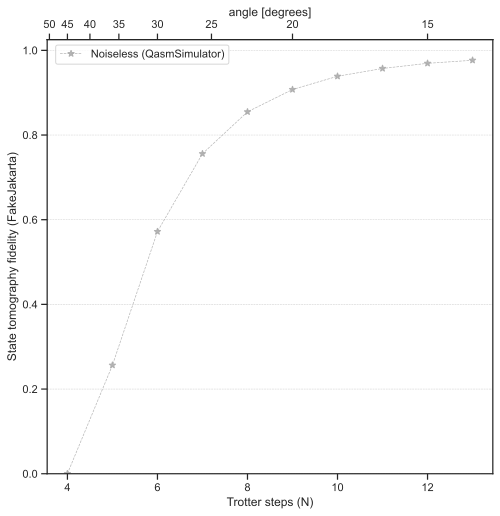

In [71]:
plot_comparisons_trotter([list_avgs_noiseless])

## Native Gates with Jakarta simulator

We can now use the Jakarta simulator, `FakeJakarta`, to evaluate the function above. 

In [72]:
list_avgs_standard = execute_Trotter_jobs(run_and_evaluate_with_steps, backend=fake_jakarta_backend, 
                                          title='Qiskit Native Gates')

Steps=4 

Qiskit Native Gates
Job ID 4b441477-33c1-4d8b-86ee-3e47be68fd00
Job ID 546fe247-b447-4225-9e06-ee2c51745e62
Job ID b871328b-ab27-4ec8-bca1-f9f5c20e7867
Job ID 0508a92e-4d87-4da1-9fab-1babb8a5f4ca
Job ID f7837650-7f2d-49ab-80ea-0c6284765d22
Job ID e9d52bdc-aec9-43f2-8827-17409ed8ca9b
Job ID 2df0b7ee-62f0-45e5-9686-0ebcfb13f077
Job ID 95e04789-8505-4816-8864-503e3594f4fe

 Duration =82336

 state tomography fidelity = 0.0577 ± 0.0018
Steps=5 

Qiskit Native Gates
Job ID f2c20a49-013c-4c22-99a2-9b81a70e9274
Job ID 96d70334-9593-4fc3-8d12-0186702ecea0
Job ID 2449d2d8-70fa-46d3-8478-52e2a38a27c3
Job ID befef05a-3762-481d-bb82-c0b82069059c
Job ID 9e61e393-3e68-44b1-a214-7db9baf55d61
Job ID 419ddd6f-640d-4984-88b4-c990d7b80e60
Job ID a9a1a884-c1b8-4ac3-9588-f7c1747d2410
Job ID 2791ed03-151c-4461-8d9b-74184a13ba69

 Duration =102880

 state tomography fidelity = 0.1430 ± 0.0009
Steps=6 

Qiskit Native Gates
Job ID b3fd8241-e78a-4887-9448-d3bf16ec1185
Job ID a6f059ac-7fbb-49f6-8168-a1

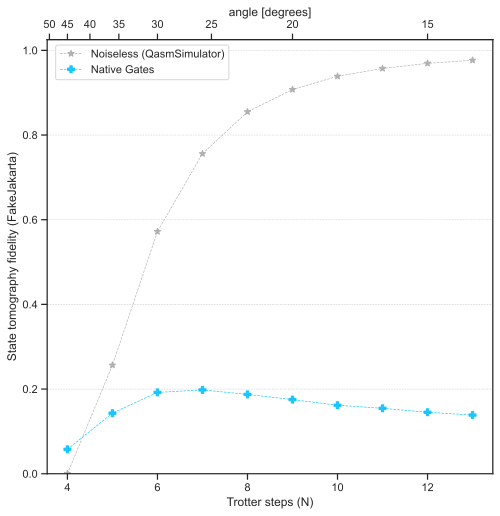

In [73]:
plot_comparisons_trotter([list_avgs_noiseless, list_avgs_standard])

As we can see from the results above, the state fidelities in noisy simulators are much lower. Using the native gates as defined in the standard qiskit library, we see that we achieve maximum state fidelities of $\approx 0.2$. As we expected, when running the circuits on noisy backend, there is a trade-off between a larger number of gates (which increases the precision of the Trotter approximation) and the duration of the circuits (which increases the likelihood of quantum decoherence).

## Native Gates - Optimization Level 3

The results from the noisy simulator are not very impressive. A simple way to improve on the results is to use one of Qiskit's predefined [pass managers](https://qiskit.org/documentation/tutorials/circuits_advanced/04_transpiler_passes_and_passmanager.html) to optimize the final circuit through different default pipelines of passes implemented on Qiskit. In the function below, we transpile the final circuit using the `optimization_level=3` option, which "collapses adjacent gates, uses a a noise-adaptive layout and a gate-cancellation procedure based on gate commutation relationships, and does resynthesis of two-qubit blocks of gates in the circuit" (see details [here](https://qiskit.org/documentation/tutorials/circuits_advanced/04_transpiler_passes_and_passmanager.html)).

Since we will be using the default Qiskit implementation, this modification is added by a single extra line of code which performs the transpilation of the final circuit with the option `optimization_level=3`.

In [74]:
def run_and_evaluate_with_steps_opt(trotter_steps, backend):
    
   ########################
    ###### Time Evolution
    ########################

    # The final time of the state evolution
    target_time = np.pi

    # Number of trotter steps
    #trotter_steps = 8  ### CAN BE >= 4

    # Initialize quantum circuit for 3 qubits
    qr = QuantumRegister(7)
    qc = QuantumCircuit(qr)

    # Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
    qc.x([3,5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

    # Simulate time evolution under H_heis3 Hamiltonian
    for _ in range(trotter_steps):
        qc.append(return_standard_Trott(target_time/trotter_steps), [qr[1], qr[3], qr[5]])


    # Generate state tomography circuits to evaluate fidelity of simulation
    st_qcs = state_tomography_circuits(qc, [qr[1], qr[3], qr[5]])
    
    # Optimization
    #  Transpile the circuit using the optimizations of optimization_level=3
    st_qcs = transpile(st_qcs, backend=backend, optimization_level=3)

    # Uncomment to see the final transpilation 
    #display(st_qcs[-1].decompose().draw())  # view decomposition of trotter gates
    
    ########################
    ###### Execution
    ########################
    
    shots = 8192
    reps = 8

    jobs = []
    for _ in range(reps):
        # execute
        job = execute(st_qcs, backend, shots=shots)
        print('Job ID', job.job_id())
        jobs.append(job)
        
    # Compute tomography fidelities for each repetition
    fids = []
    for job in jobs:
        fid = state_tomo(job.result(), st_qcs)
#        fid = state_tomo(job.result(), st_qcs)
        fids.append(fid)
        
    print('\n Duration ={:.0f}'.format(schedule(transpile(st_qcs[-1], backend),backend).duration)) 
    print('\n state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids), np.std(fids)))
    print('='*80)
    
    return(round(np.mean(fids),4))

In [75]:
list_avgs_standard_opt = execute_Trotter_jobs(run_and_evaluate_with_steps_opt, backend=fake_jakarta_backend, 
                                          title='Standard Basis Gates - Optimization Level 3')

Steps=4 

Standard Basis Gates - Optimization Level 3
Job ID c7ddef25-a0f8-4804-8869-374333359187
Job ID 81d176e0-930e-4465-aeb8-a202f3577b71
Job ID b6488d32-25a9-4cda-953e-a5f72771a019
Job ID eb0b9fa5-c1d4-468a-92a2-26da4c66a7a6
Job ID 26a25f21-b554-4208-ae81-333d75409b52
Job ID 7b348db0-258f-456e-9303-c357dd91725d
Job ID 3b7d7678-ae13-45e5-8e40-95831bc719bc
Job ID 54eef3bf-1c0c-4930-812e-94b3eef95c04

 Duration =82336

 state tomography fidelity = 0.0421 ± 0.0015
Steps=5 

Standard Basis Gates - Optimization Level 3
Job ID 0adcd5bc-3607-457b-9ea7-acf7115137fa
Job ID ed3e40f1-794e-4479-949b-8b18ce6f00c8
Job ID c176122a-fd99-421f-aadc-3d9bebfbff8d
Job ID 9f7ea929-f48f-4ec9-a0d8-c081e5aa1870
Job ID 3bcc7ef5-43c6-4ec3-9139-5a5953e61b9b
Job ID 3aa0dfc7-7f56-4d9e-b267-f2f630a8a60b
Job ID 8dcdf14d-6e5c-476f-8d48-7a7a7531782d
Job ID 89736790-296d-49ca-9818-c96b5a43c55e

 Duration =102880

 state tomography fidelity = 0.2029 ± 0.0023
Steps=6 

Standard Basis Gates - Optimization Level 3
Job I

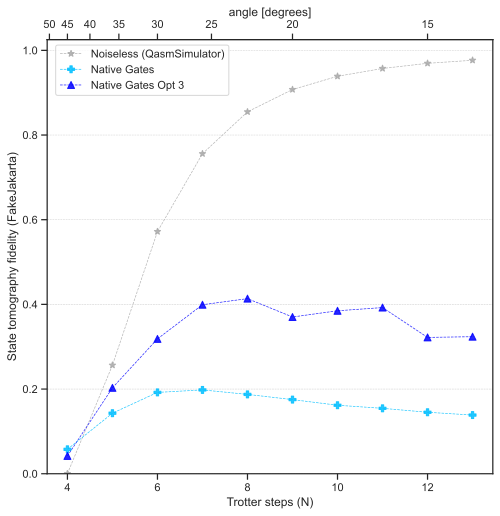

In [76]:
plot_comparisons_trotter([list_avgs_noiseless, list_avgs_standard, list_avgs_standard_opt])

The optimized gates show higher state fidelities compared to the non-optimized ones, with maximum state fidelities of $\approx 0.3-0.4$.

## Native Gates - Optimization Level 3 with Measurement Error Mitigation

A final approach using Qiskit's native gates consists in post-processing the results of the simulation using [measurement error mitigation](https://qiskit.org/documentation/tutorials/noise/3_measurement_error_mitigation.html). While there are many alternative strategies for measurement error mitigation (see, for instance [[Temme et al. 2017](https://arxiv.org/abs/1612.02058), [Kim et al. 2021](https://arxiv.org/abs/2108.09197), [Nation et al. 2021](https://arxiv.org/abs/2108.12518)]), we will use here the measurement calibrations to mitigate measurement errors as implemented in `qiskit.ignis.mitigation.measurement`. 

As described in detail in a Qiskit textbook [chapter](https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html) and in [this tutorial](https://qiskit.org/documentation/tutorials/noise/3_measurement_error_mitigation.html), the idea consists in prepare calibration circuits for the full Hilber space and estimate the expectation values of each input states in the other basis states. These results can be used to as a measurement calibration to correct the average results of other experiments.  

To implement it, we first generate a list of measurement calibrations for all $2^3=8$ basis input states using `complete_meas_cal`. We can then compute the calibration matrix based on the backend noise. In our case, we will use the noise model from the Jakarta device using `NoiseModel().from_backend(jakarta_backend)` and execute it on `sim_noise_jakarta`. With the results of the calibration matrix, we apply the calibration to the state labels using Qiskit's `CompleteMeasFitter` and generate a filter to be applied to other experiments in the same backend using a measurement filter.

The function below, `calculate_meas_filter_noise_from_backend`, implement these steps to return a measurement filter to mitigate the errors in our simulation. For the actual Jakarta experiments, we will define a similar function in Sec. [VI](#VI.-Jakarta-Runs) to return a measurement filter that was obtained directly from a run on the Jakarta backend. 



In [157]:
def calculate_meas_filter_noise_from_backend(backend = sim_noisy_jakarta):
    '''
    
    Measurement error mitigation strategy based on a simple Pauli error model 
    assigning a probability p of an X bit flip defined on function `get_noise()`. 
    
    Returns measurement filter to mitigate measurement errors applied to job results.
    
    
    '''
    qr = QuantumRegister(7)
    qubit_list=[1,3,5]
    meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')
    
    ###################################
    ## Noise model from Jakarta Backend
    ##################################
    noise_model = NoiseModel().from_backend(jakarta_backend)
    
    t_qc = transpile(meas_calibs, backend, basis_gates=noise_model.basis_gates, 
                     coupling_map=backend.configuration().coupling_map)
    qobj = assemble(t_qc, shots=10000)
    cal_results = backend.run(qobj, noise_model=noise_model,shots=10000).result()

    meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
    print('Backend Noise + Sim')
    #display(array_to_latex(meas_fitter.cal_matrix))
    
    # Get the filter object
    meas_filter = meas_fitter.filter
    

    return meas_filter

In [158]:
### Obtaining filter for measurement error mitigation
meas_filter = calculate_meas_filter_noise_from_backend(sim_noisy_jakarta)

Backend Noise + Sim


With this new function, we can modify the function `run_and_evaluate_with_steps_opt` to also return mitigated job results for each of the job runs. We do this by simply applying the measurement filter to the job results using 
```
job_mitigated_results = meas_filter.apply(job.result())
```
and estimate the fidelities using these job mitigated results.


In [169]:
def run_and_evaluate_with_steps_opt_mem(trotter_steps, backend, meas_filter=meas_filter):
    
   ########################
    ###### Time Evolution
    ########################

    # The final time of the state evolution
    target_time = np.pi


    # Initialize quantum circuit for 3 qubits
    qr = QuantumRegister(7)
    qc = QuantumCircuit(qr)

    # Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
    qc.x([3,5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

    # Simulate time evolution under H_heis3 Hamiltonian
    for _ in range(trotter_steps):
        qc.append(return_standard_Trott(target_time/trotter_steps), [qr[1], qr[3], qr[5]])


    # Generate state tomography circuits to evaluate fidelity of simulation
    st_qcs = state_tomography_circuits(qc, [qr[1], qr[3], qr[5]])
    st_qcs = transpile(st_qcs, backend=backend, optimization_level=3)
    
    ########################
    ###### Execution
    ########################
    
    shots = 8192
    reps = 8
    
    jobs = []
    jobs_mitigated =[]
    for _ in range(reps):
        # execute
        job = execute(st_qcs, backend, shots=shots)
        print('Job ID', job.job_id())     
        jobs.append(job)
        
        
    # Compute unmitigated tomography fidelities for each repetition
    fids_unmitigated = []
    for job in jobs:
        fid = state_tomo(job.result(), st_qcs)
        fids_unmitigated.append(fid)
        
        
    # Compute mitigated tomography fidelities for each repetition
    fids_mitigated = []
    for job in jobs:
        job_mitigated_results = meas_filter.apply(job.result())
        fid = state_tomo(job_mitigated_results, st_qcs) ## UF
        fids_mitigated.append(fid)
        
    print('='*80)    
    print('\n Duration ={:.0f}'.format(schedule(transpile(st_qcs[-1], backend),backend).duration)) 
    print('\n Unmitigated state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids_unmitigated), 
                                                                                   np.std(fids_unmitigated)))
    print('\n Mitigated state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids_mitigated), 
                                                                                 np.std(fids_mitigated)))
    print('='*80)
    
    return round(np.mean(fids_unmitigated),4), round(np.mean(fids_mitigated),4)
        


In [170]:
run_and_evaluate_with_steps_opt_mem(4, fake_jakarta_backend)

Job ID f6cf7ce6-ac0d-42c9-aa94-cd6854f12e89
Job ID 5e48891a-ee93-41c6-9ac5-616252e13648
Job ID 1a5c03a6-f50d-496b-ae86-c00b9fbef515
Job ID f706f4e8-0c4f-4b47-950d-1509a2910f29
Job ID 69c08580-1fd0-49b9-b062-77868eec2d14
Job ID 970371a9-7819-4671-8cd3-b721bf17fe4f
Job ID c8d65f4c-366c-403a-aabb-a984d1bb4df1
Job ID 11e4b838-e046-4c31-9801-cd5e600deb89

 Duration =62128

 Unmitigated state tomography fidelity = 0.0424 ± 0.0010

 Mitigated state tomography fidelity = 0.0441 ± 0.0014


(0.0424, 0.0441)

In [155]:
list_avgs_standard_opt, list_avgs_standard_opt_mem = execute_Trotter_jobs(run_and_evaluate_with_steps_opt_mem, 
                                                  backend=fake_jakarta_backend, 
                                                  title='Standard Basis Gates - Optimization Level 3 - MEM')


 Steps=4

Standard Basis Gates - Optimization Level 3 - MEM
Job ID 39d5625b-ac82-4fc5-86d9-5f2040dae99c
Job ID 9ce8d3e5-c17f-4bb6-9410-d1b2f401208b
Job ID 576fbebf-d7cc-44f0-ac37-01acdba4e0e7
Job ID f8b1e4e1-37d6-4e69-933e-92ec5772795d
Job ID cc5267a9-0c9f-4812-b40e-5e87d0f3ef3c
Job ID 1cd91f6b-cb51-47e5-828e-675d893082eb
Job ID 2f0b4f3b-5310-42be-ae05-9ea093b47191
Job ID 6d4b8b7d-cf9f-44c9-80c6-1bc2926bff58

 Duration =82336

 Unmitigated state tomography fidelity = 0.0347 ± 0.0010

 Mitigated state tomography fidelity = 0.0355 ± 0.0012

 Steps=5

Standard Basis Gates - Optimization Level 3 - MEM
Job ID 24c94217-323a-4b67-bc01-ad07e7f0f8db
Job ID 3f64d0b3-c434-4f27-99ba-f9946f61fd1f
Job ID a446db74-7751-47e4-9ce9-85022c3a91b9
Job ID 643b3d5b-5986-48e4-8186-fe82d642af2c
Job ID d27ac731-6a45-4f5f-9d82-2f9af6a43790
Job ID aec66616-9a82-4124-be4a-7f85b793bc58
Job ID 6a93bb5f-ba93-4bce-9c12-e4d568a6d39a
Job ID 25fa2312-1f03-4f51-ba50-4632b844e888

 Duration =102880

 Unmitigated state tom

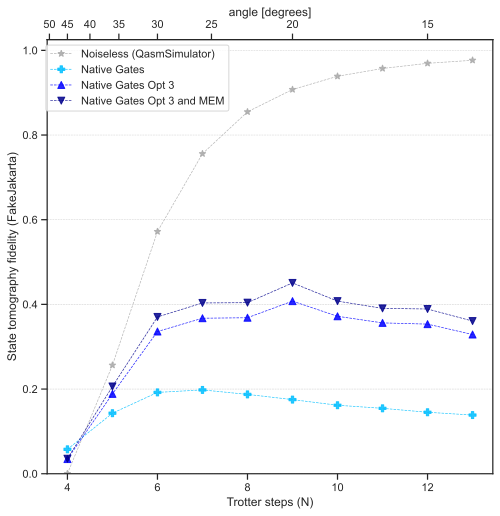

In [160]:
plot_comparisons_trotter([list_avgs_noiseless,
                          list_avgs_standard, 
                          list_avgs_standard_opt,
                          list_avgs_standard_opt_mem])

Measurement error mitigation improves the results for the state fidelities, which are not slightly higher than what was observed in unmitigated runs. 

# V. Pulse Efficient Gates with Template Optimization


As we saw in the previous section, state fidelities using native gates can be somewhat improved using circuit optimization and error mitigation. We could potentially improve the accuracy of the simulations even further by using different techniques for error mitigation such as [zero noise extrapolation](https://mitiq.readthedocs.io/en/v0.1.0/guide/guide-zne.html) using packages such as [mitiq](https://mitiq.readthedocs.io/en/v0.1.0/guide/guide-zne.html) [[LaRose et al. 2020]](https://arxiv.org/abs/2009.04417) , [quantum error correction]() etc. 

NISQ [[Preskill 2018]](https://arxiv.org/abs/1801.00862) algorithms [[Bharti et al. 2022]](https://arxiv.org/abs/2101.08448)

In this section, we will follow a different approach and use pulse efficient circuit transpilation to obtain 
[[Earnest et al. 2021]](https://arxiv.org/abs/2105.01063)


can on[Qiskit Pulse](https://qiskit.org/documentation/apidoc/pulse.html) 

Explain Template Optimization

In [112]:
###########################################
## RZZ gate

def rzz_cnot(t=np.pi):
    
    ZZ_qr = QuantumRegister(2)
    ZZ_qc = QuantumCircuit(ZZ_qr)

    ZZ_qc.cnot(0,1)
    ZZ_qc.rz(2 * t, 1)
    ZZ_qc.cnot(0,1)
        
    return ZZ_qc

def rzz_pe(t=np.pi):
    ## ZZ Pulse efficient from Earnest et al., 2021: Fig (1a)
    
    ZZ_qr = QuantumRegister(2)
    ZZ_qc = QuantumCircuit(ZZ_qr)
    
    #################### 
    ##### ZZ_pe gate
    ZZ_qc.rz(np.pi/2,1)
    ZZ_qc.sx(1)
    ZZ_qc.rz(np.pi/2,1)
    ### Native pulse RZX from Earnest et al., 2021 Fig (2c), (2d)
    ZZ_qc.rzx(t, 0, 1)
    ZZ_qc.x(0)
    ZZ_qc.rzx(-t, 0, 1)
    ZZ_qc.x(0)
    ###    
    ZZ_qc.rz(np.pi/2,1)
    ZZ_qc.sx(1)
    ZZ_qc.rz(np.pi/2,1)    
    ####################

    return ZZ_qc

###########################################
## RYY gate

def ryy_cnot(t=np.pi):
    
    YY_qr = QuantumRegister(2)
    YY_qc = QuantumCircuit(YY_qr)
    
    YY_qc.rx(np.pi/2,[0,1])
    YY_qc.cx(0,1)
    YY_qc.rz(2 * t, 1)
    YY_qc.cx(0,1)
    YY_qc.rx(-np.pi/2,[0,1])
    
    return YY_qc


def ryy_pe(t=np.pi):
    
    
    YY_qr = QuantumRegister(2)
    YY_qc = QuantumCircuit(YY_qr)

    YY_qc.rx(np.pi/2,[0,1])
    ####################
    ##### ZZ_pe gate: see above
    YY_qc.rz(np.pi/2,1)
    YY_qc.sx(1)
    YY_qc.rz(np.pi/2,1)
    ### Native pulse RZX
    YY_qc.rzx(t, 0, 1)
    YY_qc.x(0)
    YY_qc.rzx(-t, 0, 1)
    YY_qc.x(0)
    ###    
    YY_qc.rz(np.pi/2,1)
    YY_qc.sx(1)
    YY_qc.rz(np.pi/2,1)    
    ####################
    YY_qc.rx(-np.pi/2,[0,1])
    
    return YY_qc


###########################################
## RXX gate

def rxx_cnot(t=np.pi):
    
    XX_qr = QuantumRegister(2)
    XX_qc = QuantumCircuit(XX_qr)
    
    XX_qc.ry(np.pi/2,[0,1])
    XX_qc.cnot(0,1)
    XX_qc.rz(2 * t, 1)
    XX_qc.cnot(0,1)
    XX_qc.ry(-np.pi/2,[0,1])
    
    return XX_qc


def rxx_pe(t=np.pi):
    
    XX_qr = QuantumRegister(2)
    XX_qc = QuantumCircuit(XX_qr)

    XX_qc.ry(np.pi/2,[0,1])
    ####################
    ##### ZZ_pe gate: see above
    XX_qc.rz(np.pi/2,1)
    XX_qc.sx(1)
    XX_qc.rz(np.pi/2,1)
    ### Native pulse RZX
    XX_qc.rzx(t, 0, 1)
    XX_qc.x(0)
    XX_qc.rzx(-t, 0, 1)
    XX_qc.x(0)
    ###    
    XX_qc.rz(np.pi/2,1)
    XX_qc.sx(1)
    XX_qc.rz(np.pi/2,1)    
    ####################
    XX_qc.ry(-np.pi/2,[0,1])
    
    #display(XX_qc)
    
    return XX_qc



In [113]:
#rzz_template(t=np.pi)

__FIND THE SOURCE AND RUN__

In [114]:
# This code is part of Qiskit.
#
# (C) Copyright IBM 2021.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

"""
Convenience function to load RZXGate based templates.
"""

from enum import Enum
from typing import List, Dict

from qiskit.circuit.library.templates import rzx


class RZXTemplateMap(Enum):
    """Mapping of instruction name to decomposition template."""

    ZZ1 = rzx.rzx_zz1()
    ZZ2 = rzx.rzx_zz2()
    ZZ3 = rzx.rzx_zz3()
    YZ = rzx.rzx_yz()
    XZ = rzx.rzx_xz()
    CY = rzx.rzx_cy()


def rzx_templates(template_list: List[str] = None) -> Dict:
    """Convenience function to get the cost_dict and templates for template matching.
    Args:
        template_list: List of instruction names.
    Returns:
        Decomposition templates and cost values.
    """
    if template_list is None:
        template_list = ["zz1", "zz2", "zz3", "yz", "xz", "cy"]

    templates = list(map(lambda gate: RZXTemplateMap[gate.upper()].value, template_list))
    cost_dict = {"rzx": 0, "cx": 6, "rz": 0, "sx": 1, "p": 12, "h": 1, "rx": 6, "ry": 6}

    rzx_dict = {"template_list": templates, "user_cost_dict": cost_dict}

    return rzx_dict

## Compare native and pulse efficient gates

In [115]:
tt = 3*np.pi/11

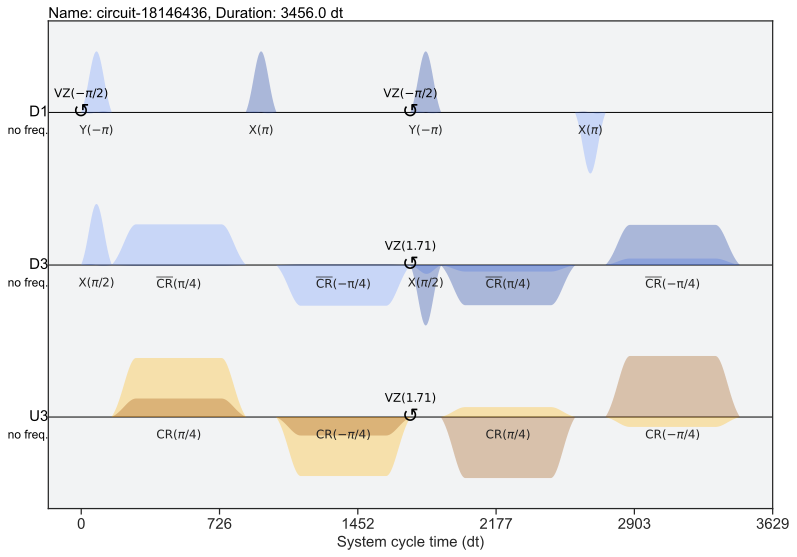

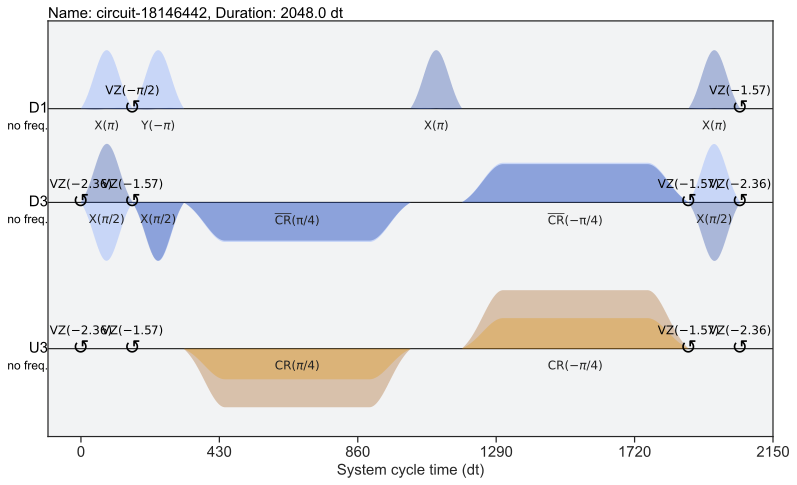

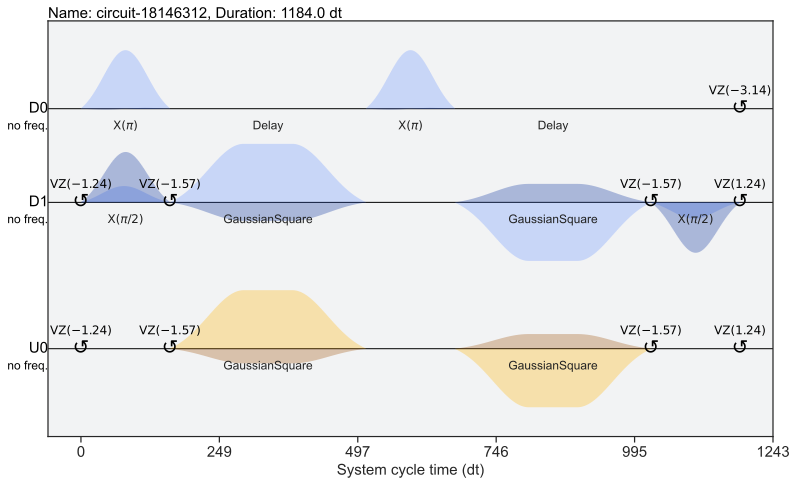

In [116]:
rzx_basis = ["rzx", "rz", "sx", "x"]
pulse_efficient = PassManager([
        # Consolidate consecutive two-qubit operations.
        Collect2qBlocks(),
        ConsolidateBlocks(basis_gates = rzx_basis),
        # Rewrite circuit in terms of Weyl-decomposed echoed RZX gates.
        EchoRZXWeylDecomposition(backend.defaults().instruction_schedule_map),
        # Attach scaled CR pulse schedules to the RZX gates.
        RZXCalibrationBuilderNoEcho(backend),
        ## Simplify single-qubit gates.
        UnrollCustomDefinitions(std_eqlib, rzx_basis),
        BasisTranslator(std_eqlib, rzx_basis),
        Optimize1qGatesDecomposition(rzx_basis),

    ]
)


pass_ = TemplateOptimization(**rzx_templates())
qc_TO = PassManager(pass_).run(rzz_pe(t=tt).decompose())

gates = ["rzx", "rz", "sx", "x"]
qc_rzx = transpile(qc_TO,
                   fake_jakarta_backend,
                   optimization_level=1,
                   basis_gates = gates)

qc_rzx.draw()
qc_pe = pulse_efficient.run(qc_rzx)

display(schedule(transpile(rzz_cnot(t=tt), fake_jakarta_backend, optimization_level=3), fake_jakarta_backend).draw())
display(schedule(transpile(rzz_pe(t=tt), fake_jakarta_backend, optimization_level=3), fake_jakarta_backend).draw())
display(schedule(qc_pe, fake_jakarta_backend).draw())

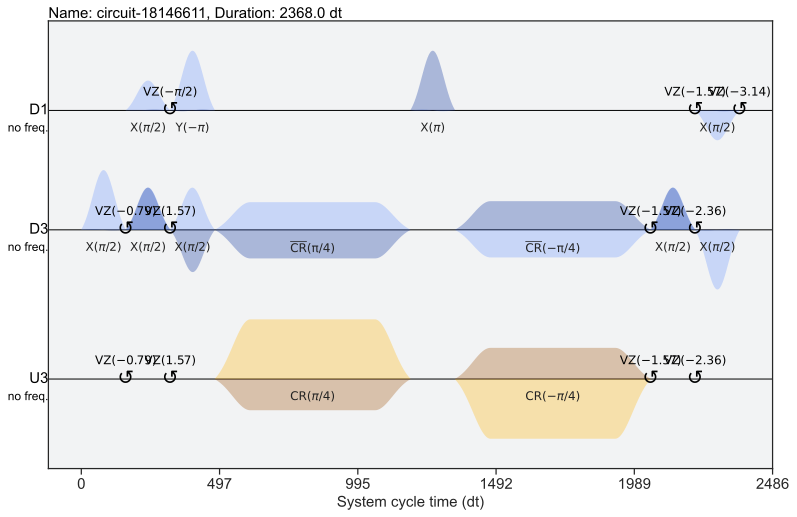

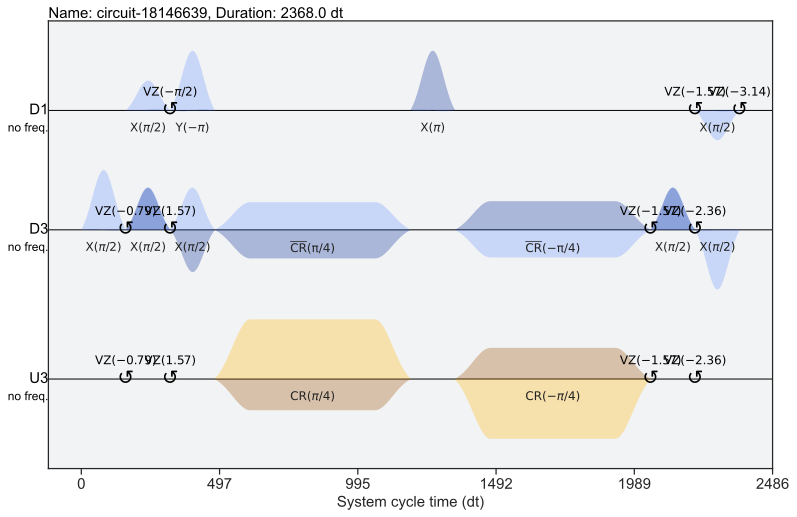

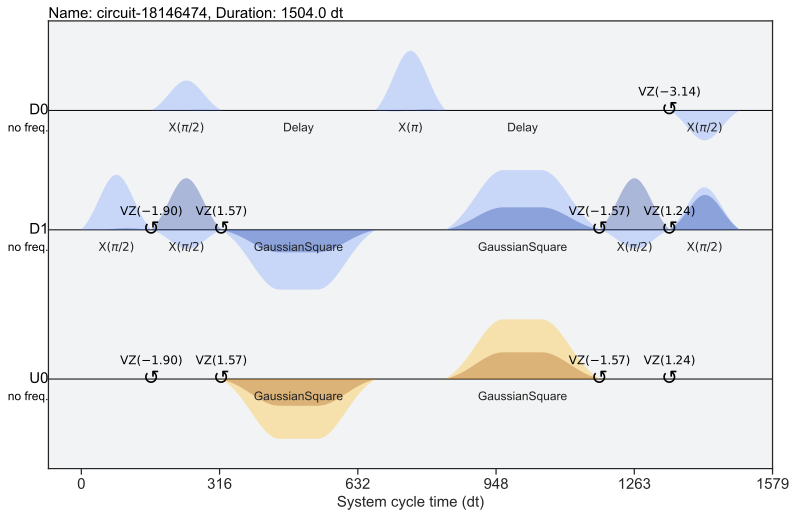

In [117]:
pass_ = TemplateOptimization(**rzx_templates())
qc_TO = PassManager(pass_).run(ryy_pe(t=tt).decompose())

gates = ["rzx", "rz", "sx", "x"]
qc_rzx = transpile(qc_TO,
                   fake_jakarta_backend,
                   optimization_level=1,
                   basis_gates = gates)

qc_rzx.draw()
qc_pe = pulse_efficient.run(qc_rzx)
display(schedule(transpile(ryy_cnot(t=tt), fake_jakarta_backend, optimization_level=3), fake_jakarta_backend).draw())
display(schedule(transpile(ryy_pe(t=tt), fake_jakarta_backend, optimization_level=3), fake_jakarta_backend).draw())
display(schedule(qc_pe, fake_jakarta_backend).draw())

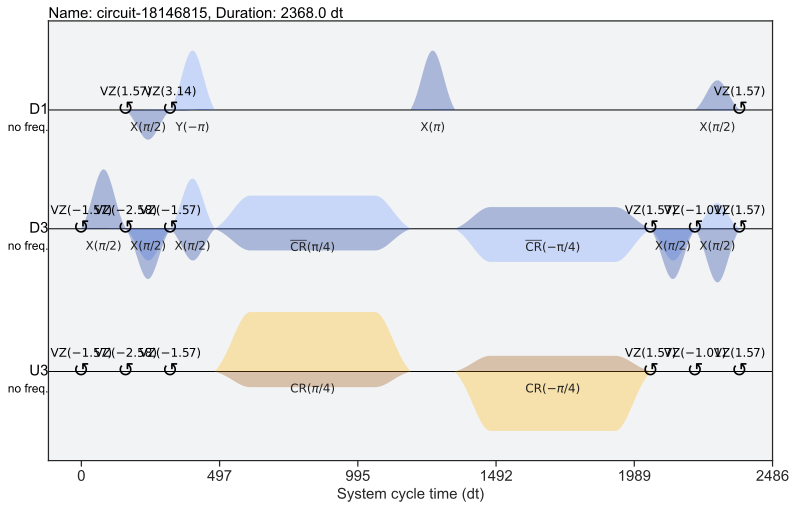

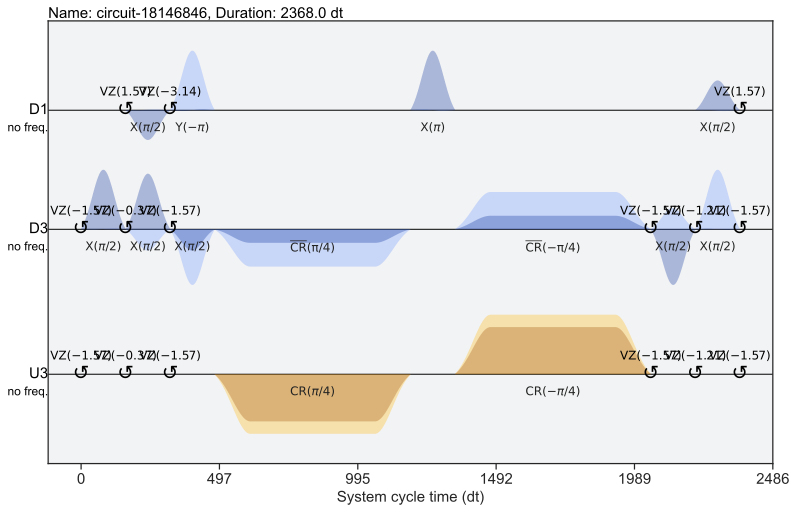

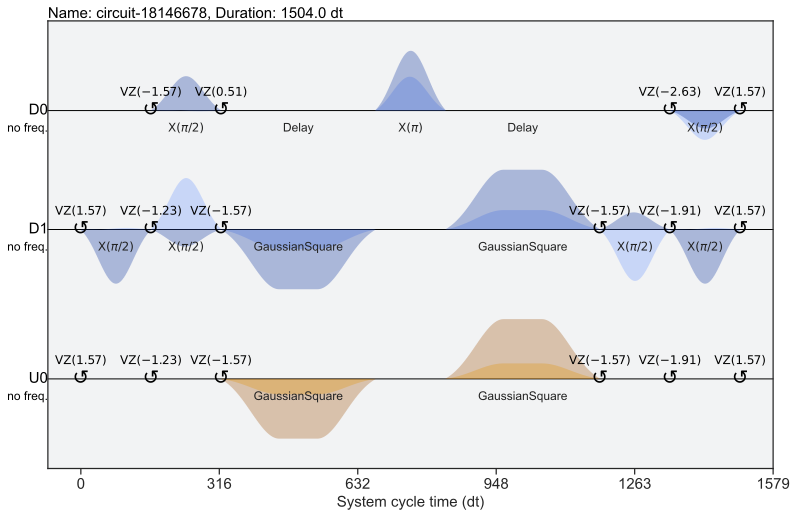

In [118]:
pass_ = TemplateOptimization(**rzx_templates())
qc_TO = PassManager(pass_).run(rxx_pe(t=tt).decompose())

gates = ["rzx", "rz", "sx", "x"]
qc_rzx = transpile(qc_TO,
                   fake_jakarta_backend,
                   optimization_level=1,
                   basis_gates = gates)

qc_rzx.draw()
qc_pe = pulse_efficient.run(qc_rzx)
display(schedule(transpile(rxx_cnot(t=tt), fake_jakarta_backend, optimization_level=3), fake_jakarta_backend).draw())
display(schedule(transpile(rxx_pe(t=tt), fake_jakarta_backend, optimization_level=3), fake_jakarta_backend).draw())
display(schedule(qc_pe, fake_jakarta_backend).draw())

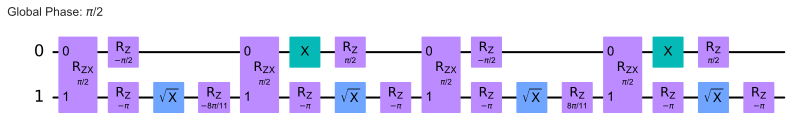

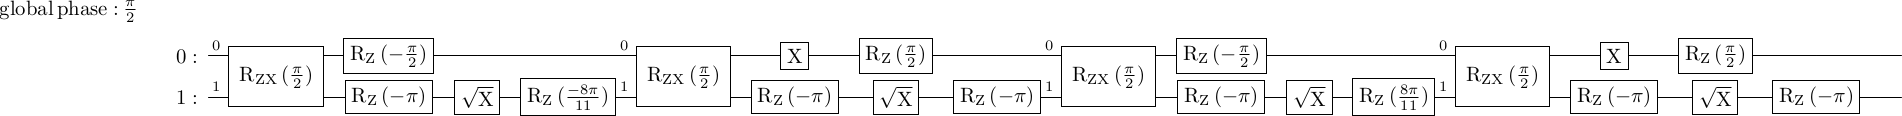

In [119]:
pass_ = TemplateOptimization(**rzx_templates())
qc_TO = PassManager(pass_).run(rzz_pe(t=3*np.pi/11).decompose())

gates = ["rzx", "rz", "sx", "x"]
qc_rzx = transpile(qc_TO,
                   fake_jakarta_backend,
                   optimization_level=1,
                   basis_gates = gates)

qc_rzx = remove_idle_qwires(qc_rzx)
display(qc_rzx.draw())
qc_rzx.draw('latex')

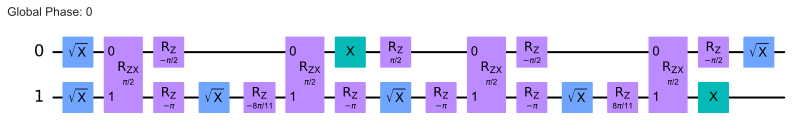

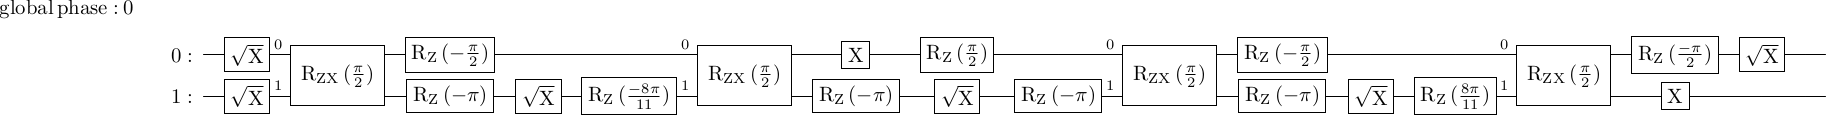

In [120]:
pass_ = TemplateOptimization(**rzx_templates())
qc_TO = PassManager(pass_).run(ryy_pe(t=3*np.pi/11).decompose())

gates = ["rzx", "rz", "sx", "x"]
qc_rzx = transpile(qc_TO,
                   fake_jakarta_backend,
                   optimization_level=1,
                   basis_gates = gates)

qc_rzx = remove_idle_qwires(qc_rzx)
display(qc_rzx.draw())
qc_rzx.draw('latex')

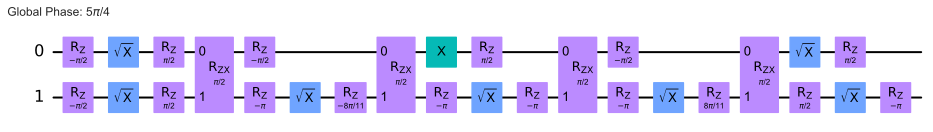

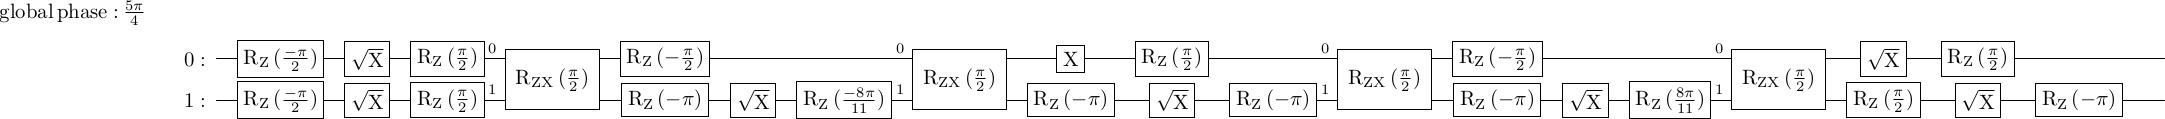

In [121]:
pass_ = TemplateOptimization(**rzx_templates())
qc_TO = PassManager(pass_).run(rxx_pe(t=3*np.pi/11).decompose())

gates = ["rzx", "rz", "sx", "x"]
qc_rzx = transpile(qc_TO,
                   fake_jakarta_backend,
                   optimization_level=1,
                   basis_gates = gates)

qc_rzx = remove_idle_qwires(qc_rzx)
display(qc_rzx.draw())
qc_rzx.draw('latex')

### Finding pulse efficient gates

In [122]:
def find_pulse_efficient_gate(gate = rzz_cnot):
    '''
    Usage: find_pulse_efficient_gates(t=np.pi, template_list=[rzz_template(t=t)], gate = rzz(t=t))
    
    '''
        
    rzx_basis = ["rzx", "rz", "sx", "x",'cx']
    pulse_efficient = PassManager([
            # Consolidate consecutive two-qubit operations.
            Collect2qBlocks(),
            ConsolidateBlocks(basis_gates = rzx_basis),
            # Rewrite circuit in terms of Weyl-decomposed echoed RZX gates.
            EchoRZXWeylDecomposition(backend.defaults().instruction_schedule_map),
            # Attach scaled CR pulse schedules to the RZX gates.
            RZXCalibrationBuilderNoEcho(backend),
            ## Simplify single-qubit gates.
            UnrollCustomDefinitions(std_eqlib, rzx_basis),
            BasisTranslator(std_eqlib, rzx_basis),
            Optimize1qGatesDecomposition(rzx_basis),
        
        ]
    )

#     # Template Optimization - see Earnest+ 
#     pass_ = TemplateOptimization(template_list=template_list, 
#                                  user_cost_dict= cost_dict)

    # Template Optimization - see Earnest+ 
    pass_ = TemplateOptimization(**rzx_templates())

    
    qc_TO = PassManager(pass_).run(gate.decompose())

    gates = ["rzx", "rz", "sx", "x"]
    qc_rzx = transpile(qc_TO,
                       backend,
                       optimization_level=1,
                       basis_gates = gates)
    
    
    qc_pe = pulse_efficient.run(qc_rzx)

    if t%np.pi==0:
        qc_pe.i([0,1])
        qc_pe = remove_idle_qwires(qc_pe)

    else:
        qc_pe = remove_idle_qwires(qc_pe)
    
    return qc_pe#two_q_gate

## Template Optimization with Measurement Error Mitigation

Run error mitigation or read measurement error mitigation job

Using `meas_filter` defined in [[4.5]](#Native-Gates---Optimization-Level-3-with-Measurement-Error-Mitigation)

In [129]:
### Applying filter for measurement error mitigation
meas_filter = calculate_meas_filter(jakarta_backend)
#meas_filter = calculate_meas_filter_noise(sim_noisy_jakarta, noise_level=noise_level)


In [130]:
def run_and_evaluate_with_steps_pe_mem(trotter_steps, backend, meas_filter=meas_filter):
    
   ########################
    ###### Time Evolution
    ########################
    pulse_efficient = PassManager([
        # Consolidate consecutive two-qubit operations.
        Collect2qBlocks(),
        ConsolidateBlocks(basis_gates = rzx_basis),
        # Rewrite circuit in terms of Weyl-decomposed echoed RZX gates.
        EchoRZXWeylDecomposition(backend.defaults().instruction_schedule_map),
        # Attach scaled CR pulse schedules to the RZX gates.
        RZXCalibrationBuilderNoEcho(backend),
        ## Simplify single-qubit gates.
        UnrollCustomDefinitions(std_eqlib, rzx_basis),
        BasisTranslator(std_eqlib, rzx_basis),
        Optimize1qGatesDecomposition(rzx_basis)
    ])

    # The final time of the state evolution
    target_time = np.pi

    # Number of trotter steps
    #trotter_steps = 8  ### CAN BE >= 4

    # Initialize quantum circuit for 3 qubits
    qr = QuantumRegister(7, name='qrT')
    qc = QuantumCircuit(qr)

    # Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
    qc.x([3,5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

    for _ in range(trotter_steps):
        qc.append(rzz_pe((target_time/trotter_steps)), [1,3])
        qc.append(ryy_pe((target_time/trotter_steps)), [1,3])
        qc.append(rxx_pe((target_time/trotter_steps)), [1,3])

        qc.append(rzz_pe((target_time/trotter_steps)), [3,5])
        qc.append(ryy_pe((target_time/trotter_steps)), [3,5])
        qc.append(rxx_pe((target_time/trotter_steps)), [3,5])


    #display(qc.draw())
    pass_ = TemplateOptimization(**rzx_templates())
    qc_TO = PassManager(pass_).run(qc.decompose())

    gates = ["rzx", "rz", "sx", "x"]
    transpiled_qc_rzx = transpile(qc_TO,
                       fake_jakarta_backend,
                       optimization_level=1,
                       basis_gates = gates)

    #display(transpiled_qc_rzx.draw())
    qc_pe = pulse_efficient.run(transpiled_qc_rzx)

    #Generate state tomography circuits to evaluate fidelity of simulation
    st_qcs = state_tomography_circuits(qc_pe, [1,3,5])

    ########################
    ###### Execution
    ########################
    
    shots = 8192
    reps = 8


    jobs = []
    for _ in range(reps):
        # execute
        job = execute(st_qcs, backend, shots=shots)
        print('Job ID', job.job_id())
        jobs.append(job)
        
    # Compute unmitigated tomography fidelities for each repetition
    fids_unmitigated = []
    for job in jobs:
        fid = state_tomo(job.result(), st_qcs)
    #         print(job.result())
    #    job_mitigated_results = meas_filter.apply(job.result())
    #    fid = state_tomo(job_mitigated_results, st_qcs) ## UF
        fids_unmitigated.append(fid)
        
    # Compute mitigated tomography fidelities for each repetition
    fids_mitigated = []
    for job in jobs:
#        fid = state_tomo(job.result(), st_qcs)
#         print(job.result())
        job_mitigated_results = meas_filter.apply(job.result())
        fid = state_tomo(job_mitigated_results, st_qcs) ## UF
        fids_mitigated.append(fid)
        
    print('='*80)    
    print('\n Duration ={:.0f}'.format(schedule(transpile(qc_pe, backend),backend).duration)) 
    print('\n Unmitigated state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids_unmitigated), 
                                                                                   np.std(fids_unmitigated)))
    print('\n Mitigated state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fids_mitigated), 
                                                                                 np.std(fids_mitigated)))
    print('='*80)
    
    return round(np.mean(fids_unmitigated),4), round(np.mean(fids_mitigated),4)

In [131]:
#run_and_evaluate_with_steps_pe_mem(4, fake_jakarta_backend)

In [132]:
list_avgs_standard_pe, list_avgs_standard_pe_mem = execute_Trotter_jobs(run_and_evaluate_with_steps_pe_mem, 
                                             backend=fake_jakarta_backend, 
                                             title='PE Template Optimization and MEM')


 Steps=4

PE Template Optimization and MEM
Job ID e50ffbe8-5cc8-41f7-9689-59b5ff621173
Job ID 21f5c580-7b82-4e71-8805-2d5fa278d4c3
Job ID a80d840e-a907-48d4-86db-217b45555c3b
Job ID 872c55b2-1d0a-4f09-a128-4df62350b787
Job ID 9a85047a-d0d6-4786-9a57-5de5092c14c4
Job ID 571dbde9-1df8-42d5-8848-a78f1e66612c
Job ID 4b7aa6b4-b434-430e-a575-589748907583
Job ID 122fe19b-33ad-47dd-be95-9d4d84905b01

 Duration =43392

 Unmitigated state tomography fidelity = 0.0042 ± 0.0006

 Mitigated state tomography fidelity = 0.0006 ± 0.0006

 Steps=5

PE Template Optimization and MEM
Job ID f5a1de74-d344-4c58-ae7e-4d7916d55a31
Job ID 6cfa78d6-4931-49f7-a881-5571a9d8db32
Job ID 4b3e22c4-b899-4252-93b4-447c881fd4ca
Job ID 2bb12a65-d4e0-4c0f-81f4-576e9af27369
Job ID 5f4ac6fa-9566-422a-87ff-946f0e8fa62e
Job ID a32595a1-9228-40a3-ac86-99356affca33
Job ID ec112175-9dd6-4c26-886a-34f62424eeb3
Job ID cc816ac2-63bd-451b-ab50-4960861b07f1

 Duration =47680

 Unmitigated state tomography fidelity = 0.2268 ± 0.0013


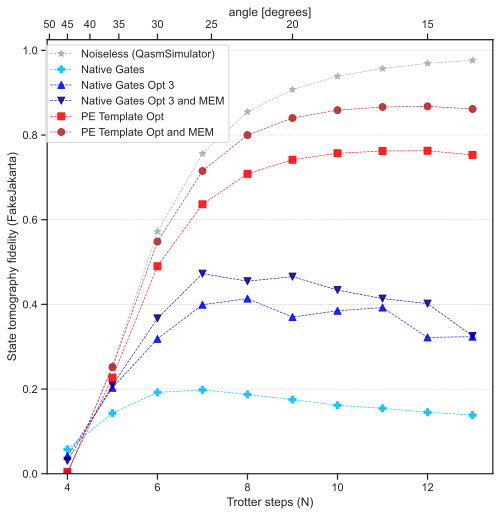

In [133]:
plot_comparisons_trotter([list_avgs_noiseless,
                          list_avgs_standard, 
                          list_avgs_standard_opt,
                          list_avgs_standard_opt_mem, 
                          list_avgs_standard_pe,
                          list_avgs_standard_pe_mem])

# VI. Jakarta Experiments

Goal: run $n=8, 10, 11$ Trotter steps with MEM on actual quantum device

We have separate runs for the Trotter calculation and for the measurement error mitigation.

Reading runs from Jakarta

## Native  gates - Optimization Level 3 with Measurement Error Mitigation

### Qiskit's Error Mitigation

In [ ]:
def calculate_meas_filter(backend=jakarta_backend, running_on_device = False, job_id = '625647d29def42732fa98d01'):
    '''
    
    Measurement error mitigation strategy based on a simple Pauli error model 
    assigning a probability p of an X bit flip defined on function `get_noise()`. 
    
    Returns measurement filter to mitigate measurement errors applied to job results.
    
    
    '''
    qr = QuantumRegister(7)
    qubit_list=[1,3,5]
    meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')

    ## used to run on device. Once it is run, just pull the results from the jobs 
    if running_on_device == True:
        # Execute the calibration circuits without noise
        t_qc = transpile(meas_calibs, backend)
        qobj = assemble(t_qc, shots=10000)
        cal_results = backend.run(qobj, shots=10000).result()
    else:
#        job_id = '625647d29def42732fa98d01' # Default is calibration from jakarta
        cal_results = backend.retrieve_job(job_id).result()

    meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
    # Get the filter object
    meas_filter = meas_fitter.filter

    return meas_filter

In [ ]:
## complete_meas_cal from job on device
#meas_filter = calculate_meas_filter(jakarta_backend, running_on_device = False)
#meas_filter = calculate_meas_filter(jakarta_backend)

In [ ]:
def run_and_evaluate_with_steps_opt_mem_jakarta(trotter_steps, backend, meas_filter = meas_filter, 
                                               read_or_run = 'read', list_jobs=None):
    '''
    This function reads jobs already on device or runs new ones using the same approach as   
    `run_and_evaluate_with_steps_opt_mem` from section 3.5
    
    Usage: run_and_evaluate_with_steps_opt_mem_device(trotter_steps, backend, meas_filter = meas_filter, 
                                                        read_or_run = 'read', list_jobs=None)
                                               
    trotter_steps: number of Trotter steps 
    backend: device or simulation backend.
    meas_filter: meas_filter calculated on backend
    read_or_run: 'read' to read finished jobs or 'run'to run new ones. Default is 'read'
    list_jobs: list of jobs already executed on device. Default is None
    
    Returns: Mean fidelity of statevector compared to target_state
    '''
            

   ########################
    ###### Time Evolution
    ########################

    # The final time of the state evolution
    target_time = np.pi

    # Number of trotter steps
    #trotter_steps = 8  ### CAN BE >= 4

    # Initialize quantum circuit for 3 qubits
    qr = QuantumRegister(7)
    qc = QuantumCircuit(qr)

    # Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
    qc.x([3,5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

    # Simulate time evolution under H_heis3 Hamiltonian
    for _ in range(trotter_steps):
        qc.append(return_standard_Trott(target_time/trotter_steps), [qr[1], qr[3], qr[5]])

#     # Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
#     qc = qc.bind_parameters({t: target_time/trotter_steps})

    # Generate state tomography circuits to evaluate fidelity of simulation
    st_qcs = state_tomography_circuits(qc, [qr[1], qr[3], qr[5]])
    st_qcs = transpile(st_qcs, backend=backend, optimization_level=3)
#    st_qcs = transpile(st_qcs, backend=backend, optimization_level=1)

    # Display circuit for confirmation
    # st_qcs[-1].decompose().draw()  # view decomposition of trotter gates

    if read_or_run == 'run': 
    
        ########################
        ###### Execution
        ########################
        
        shots = 8192
        reps = 8

        jobs = []
        for _ in range(reps):
            # execute
            job = execute(st_qcs, backend, shots=shots)
            print('Job ID', job.job_id())
    

    elif read_or_run == 'read':
        ########################
        ###### READ
        ########################
        
        if list_jobs == None:
            print("Provide list_jobs")
        else:
            jobs = []
            for j in list_jobs:
                # retrieve
                job = backend.retrieve_job(j)
                print('Job ID', job.job_id())
                jobs.append(job)
        

    else:
        print('Define `read_or_run`')
        
    # Compute tomography fidelities for each repetition
    fids = []
    for job in jobs:
        job_mitigated_results = meas_filter.apply(job.result())
        fid = state_tomo(job_mitigated_results, st_qcs) ## UF
        fids.append(fid)
    
    print('='*50)    
    print('\n state tomography fidelity = {:.4f} \u00B1 {:.4f} \n'.format(np.mean(fids), np.std(fids)))
    print('='*50)
    
    return(round(np.mean(fids),4))

Actual run of the Trotter circuit on the Jakarta device.

In [ ]:
# from opt-mem nb
list_jobs_n8_run4 = ['62473687b3213d24e5c05a9e', 
                     '62473689b3213d153ec05a9f',
                     '6247368b1a95e0f94a5cd571',
                     '6247368db3213da161c05aa0',
                     '6247368eb3213d4496c05aa1',
                     '6247369099622559498bad70',
                     '62473692e978c7a07afb1860',
                     '62473693b3213da123c05aa2']  ## Trotter n=8  

In [ ]:
run_and_evaluate_with_steps_opt_mem_jakarta(8, jakarta_backend, meas_filter, read_or_run='read', 
                                           list_jobs=list_jobs_n8_run4)

## Pulse Efficient Template Optimization

### Qiskit's Error Mitigation

In [ ]:
def run_and_evaluate_with_steps_pe_mem_jakarta(trotter_steps, backend, meas_filter = meas_filter, 
                                               read_or_run = 'read', list_jobs=None):
    '''
    This function reads jobs already on device or runs new ones using the same approach as   
    `run_and_evaluate_with_steps_opt_mem` from section 3.5
    
    Usage: run_and_evaluate_with_steps_opt_mem_device(trotter_steps, backend, meas_filter = meas_filter, 
                                                        read_or_run = 'read', list_jobs=None)
                                               
    trotter_steps: number of Trotter steps 
    backend: device or simulation backend.
    meas_filter: meas_filter calculated on backend
    read_or_run: 'read' to read finished jobs or 'run'to run new ones. Default is 'read'
    list_jobs: list of jobs already executed on device. Default is None
    
    Returns: Mean fidelity of statevector compared to target_state
    '''
    
   ########################
    ###### Time Evolution
    ########################
    pulse_efficient = PassManager([
        # Consolidate consecutive two-qubit operations.
        Collect2qBlocks(),
        ConsolidateBlocks(basis_gates = rzx_basis),
        # Rewrite circuit in terms of Weyl-decomposed echoed RZX gates.
        EchoRZXWeylDecomposition(backend.defaults().instruction_schedule_map),
        # Attach scaled CR pulse schedules to the RZX gates.
        RZXCalibrationBuilderNoEcho(backend),
        ## Simplify single-qubit gates.
        UnrollCustomDefinitions(std_eqlib, rzx_basis),
        BasisTranslator(std_eqlib, rzx_basis),
        Optimize1qGatesDecomposition(rzx_basis)
    ])

    # The final time of the state evolution
    target_time = np.pi

    # Number of trotter steps
    #trotter_steps = 8  ### CAN BE >= 4

    # Initialize quantum circuit for 3 qubits
    qr = QuantumRegister(7, name='qrT')
    qc = QuantumCircuit(qr)

    # Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
    qc.x([3,5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

    for _ in range(trotter_steps):
        qc.append(rzz_pe((target_time/trotter_steps)), [1,3])
        qc.append(ryy_pe((target_time/trotter_steps)), [1,3])
        qc.append(rxx_pe((target_time/trotter_steps)), [1,3])

        qc.append(rzz_pe((target_time/trotter_steps)), [3,5])
        qc.append(ryy_pe((target_time/trotter_steps)), [3,5])
        qc.append(rxx_pe((target_time/trotter_steps)), [3,5])


    #display(qc.draw())
    pass_ = TemplateOptimization(**rzx_templates())
    qc_TO = PassManager(pass_).run(qc.decompose())

    gates = ["rzx", "rz", "sx", "x"]
    transpiled_qc_rzx = transpile(qc_TO,
                       fake_jakarta_backend,
                       optimization_level=1,
                       basis_gates = gates)

    #display(transpiled_qc_rzx.draw())
    qc_pe = pulse_efficient.run(transpiled_qc_rzx)

    #Generate state tomography circuits to evaluate fidelity of simulation
    st_qcs = state_tomography_circuits(qc_pe, [1,3,5])

    if read_or_run == 'run': 
        ########################
        ###### Execution
        ########################

        shots = 8192
        reps = 8


        jobs = []
        for _ in range(reps):
            # execute
            job = execute(st_qcs, backend, shots=shots)
            print('Job ID', job.job_id())
            jobs.append(job)
            
    elif read_or_run == 'read':
        ########################
        ###### READ
        ########################
        
        if list_jobs == None:
            print("Provide list_jobs")
        else:
            jobs = []
            for j in list_jobs:
                # retrieve
                job = backend.retrieve_job(j)
                print('Job ID', job.job_id())
                jobs.append(job)
        

    else:
        print('Define `read_or_run`')
        
    # Compute tomography fidelities for each repetition
    fids = []
    for job in jobs:
#        fid = state_tomo(job.result(), st_qcs)
#         print(job.result())
        job_mitigated_results = meas_filter.apply(job.result())
        fid = state_tomo(job_mitigated_results, st_qcs) ## UF
        fids.append(fid)
        
    print('='*50)    
    print('\n state tomography fidelity = {:.4f} \u00B1 {:.4f} \n'.format(np.mean(fids), np.std(fids)))
    print('='*50)
    
    return(round(np.mean(fids),4))

$N=8$

In [ ]:
list_jobs_pe_n8_run1 = ['625b5ae0f1fb8d40af3ad927',
                        '625b5ae4e1f245f2cdeb6ce4',
                        '625b5ae90d8f19451bac1aaa',
                        '625b5aed9e311582cf838b50',
                        '625b5af13bbc9fb061735c4e',
                        '625b5af5736894b9c6c8bce7',
                        '625b5af98e4b23cb72d30a36',
                        '625b5afda7e9666acddee870']

run_and_evaluate_with_steps_pe_mem_jakarta(8, jakarta_backend, meas_filter, read_or_run='read', 
                                           list_jobs=list_jobs_pe_n8_run1)

$N=11$

In [ ]:
list_jobs_pe_n11_run1 = ['625b5cc473689461f9c8bced',
                        '625b5cca8e4b231934d30a38',
                        '625b5cce35e1ec41d9253740',
                        '625b5cd3f1fb8d67323ad92d',
                        '625b5cd87368941e87c8bcee',
                        '625b5cdda7e96664addee873',
                        '625b5ce20d8f1980abac1aaf',
                        '625b5ce7e3b67fc84a3abd81']

run_and_evaluate_with_steps_pe_mem_jakarta(11, jakarta_backend, meas_filter, read_or_run='read', 
                                           list_jobs=list_jobs_pe_n11_run1)

In [ ]:
### ZNE

In [ ]:
### ZNE list of jobs
# list_jobs_pe__zne_n8_run2 = ['625b638de1f2454bfaeb6cf8',
#                             '625b638fe1f245144ceb6cf9',
#                             '625b6392e3b67f21b63abd90',
#                             '625b63949e31154ea4838b5c',
#                             '625b6396e1f245f0a4eb6cfa',
#                             '625b6398a7e9669575dee87c',
#                             '625b639a3bbc9f3d66735c5f',
#                             '625b639fe3b67fa15a3abd91']

# list_jobs_pe__zne_n11_run1 = ['625b657ee1f24566fceb6d02',
#                             '625b65819e31158629838b5f',
#                             '625b6584a7e9667c67dee880',
#                             '625b65873bbc9f290e735c62',
#                             '625b6589e3b67f59143abd94',
#                             '625b658ce1f2457306eb6d03',
#                             '625b658e9e311592e4838b61',
#                             '625b659135e1ecbe6f253753'
#                              ]

# #What about '625b5d9ea7e9668cb6dee876'

# VII. Future Directions

[zero noise extrapolation](https://mitiq.readthedocs.io/en/v0.1.0/guide/guide-zne.html) [[LaRose et al. 2020]](https://arxiv.org/abs/2009.04417)

Augmented basis gate set with pulse ([[Smith et al. 2022]](https://arxiv.org/abs/2202.13600), [[Gokhale et al. 2020]](https://arxiv.org/abs/2004.11205))

Implementation of mem [[Kandala et al. 2019]](https://arxiv.org/abs/1805.04492)



# VIII. References


[[Alexander et al. 2020]](https://arxiv.org/abs/2004.06755) Alexander, T., N. Kanazawa, D. J. Egger, L. Capelluto, C. J. Wood, A. Javadi-Abhari, and D. C. McKay (2020), Quan- tum Science and Technology 5 (4), 044006.

[[Bharti et al. 2022]](https://arxiv.org/abs/2101.08448) Bharti, K., A. Cervera-Lierta, T. H. Kyaw, T. Haug, S. Alperin-Lea, A. Anand, M. Degroote, H. Heimonen, J. S. Kottmann, T. Menke, W.-K. Mok, S. Sim, L.-C. Kwek, and A. Aspuru-Guzik (2022), Reviews of Modern Physics 94 (1), 10.1103/revmodphys.94.015004.

[[Earnest et al. 2021]](https://arxiv.org/abs/2105.01063) Earnest, N., C. Tornow, and D. J. Egger (2021), Physical Review Research 3 (4), 10.1103/physrevresearch.3.043088.

[[Gokhale et al. 2020]](https://arxiv.org/abs/2004.11205) Gokhale, P., A. Javadi-Abhari, N. Earnest, Y. Shi, and F. T. Chong (2020), “Optimized quantum compilation for near-term algorithms with openpulse,” 	arXiv:2004.11205 [quant-ph].

[[Heras et al. 2014]](https://arxiv.org/abs/1311.7626) Heras, U. L., A. Mezzacapo, L. Lamata, S. Filipp, A. Wallraff,
and E. Solano (2014), Physical Review Letters 112 (20),
10.1103/physrevlett.112.200501.

[[Kandala et al. 2019]](https://arxiv.org/abs/1805.04492) Kandala, A., K. Temme, A. D. Córcoles, A. Mezzacapo, J. M. Chow, and J. M. Gambetta (2019), Nature 567, 491.

[[Kim et al. 2021]](https://arxiv.org/abs/2108.09197) Kim, Y., C. J. Wood, T. J. Yoder, S. T. Merkel, J. M. Gambetta, K. Temme, and A. Kandala (2021), “Scalable error mitigation for noisy quantum circuits produces competitive expectation values,” arXiv:2108.09197 [quant-ph].

[[LaRose et al. 2020]](https://arxiv.org/abs/2009.04417) LaRose, R., A. Mari, S. Kaiser, P. J. Karalekas, A. A. Alves,
P. Czarnik, M. E. Mandouh, M. H. Gordon, Y. Hindy, A. Robertson, P. Thakre, N. Shammah, and W. J. Zeng (2020), “Mitiq: A software package for error mitigation on noisy quantum computers,” arXiv:2009.04417 [quant-ph].

[[Lloyd 1996]](https://www.science.org/doi/10.1126/science.273.5278.1073) Lloyd, S. (1996), Science 273 (5278), 1073.

[[Nation et al. 2021]](https://arxiv.org/abs/2108.12518) Nation, P. D., H. Kang, N. Sundaresan, and J. M. Gambetta (2021), PRX Quantum 2 (4), 10.1103/prxquantum.2.040326. 

[[Preskill 2018]](https://arxiv.org/abs/1801.00862) Preskill, J. (2018), Quantum 2, 79.

[[Salathé et al. 2015]](https://arxiv.org/abs/1502.06778)*** Salathé, Y., M. Mondal, M. Oppliger, J. Heinsoo, P. Kurpiers, A. Potocnik, A. Mezzacapo, U. Las Heras, L. Lamata, E. Solano, S. Filipp, and A. Wallraff (2015), Phys. Rev. X 5, 021027.

[[Smith et al. 2019]](https://arxiv.org/abs/1906.06343)*** Smith, A., M. S. Kim, F. Pollmann, and J. Knolle (2019), npj Quantum Information 5 (1), 10.1038/s41534-019-0217-0.

[[Smith et al. 2022]](https://arxiv.org/abs/2202.13600) Smith, K. N., G. S. Ravi, T. Alexander, N. T. Bronn, A. Carvalho, A. Cervera-Lierta, F. T. Chong, J. M. Chow, M. Cubeddu, A. Hashim, L. Jiang, O. Lanes, M. J. Otten, D. I. Schuster, P. Gokhale, N. Earnest, and A. Galda (2022), “Summary: Chicago quantum exchange (cqe) pulse-level quantum control workshop,” arXiv:2202.13600 [quant-ph].

[[Tacchino et al. 2019]](https://arxiv.org/abs/1907.03505) Tacchino, F., A. Chiesa, S. Carretta, and D. Gerace (2019),
Advanced Quantum Technologies 3 (3), 1900052.

[[Temme et al. 2017]](https://arxiv.org/abs/1612.02058) Temme, K., S. Bravyi, and J. M. Gambetta (2017), Physical Review Letters 119 (18), 10.1103/physrevlett.119.180509.



In [172]:
import qiskit.tools.jupyter
%qiskit_version_table